pip install missingno

pip install lightgbm

In [95]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, power_transform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#library for error detection in regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error

#libraries for regularisation
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV

#library for EDA
from scipy.stats import zscore

#Library for saving data
import pickle

#model evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#library for GridSearchCV 
from sklearn.model_selection import GridSearchCV

In [37]:
df=pd.read_excel('flight.xlsx')

#show all columns in dataframe
pd.set_option('display.max_columns', None)


df.head(5)

,Price,Flightname,Sourceplace,DestinationPlace,ArrivalTime,Stops,Sourcetime,Date,day
0,"5,953",Air Asia,New Delhi,Mumbai,06:45\n+ 1 day,1 Stop,21:25,1 Nov,Mon
1,"5,953",Air Asia,New Delhi,Mumbai,07:15\n+ 1 day,1 Stop,21:25,1 Nov,Mon
2,"5,953",Air Asia,New Delhi,Mumbai,06:45\n+ 1 day,1 Stop,18:35,1 Nov,Mon
3,"5,953",Air Asia,New Delhi,Mumbai,07:15\n+ 1 day,1 Stop,18:35,1 Nov,Mon
4,"5,953",Air Asia,New Delhi,Mumbai,12:25\n+ 1 day,1 Stop,22:10,1 Nov,Mon


Here we are taking a look at the first 5 and last 5 rows of our entire training data set. It looks like the only column that has proper numeric data is "Price" which is also our target column making all the remaining columns as our features using which we need to predict our label. Since the values present in the "Price" column has continous data it makes this to be a Regression problem!

# Statistical data analysis

In [38]:
df.describe(include='all')

,Price,Flightname,Sourceplace,DestinationPlace,ArrivalTime,Stops,Sourcetime,Date,day
count,2385,2385,2385,2385,2385,2385,2385,2385,2385
unique,608,6,1,1,165,4,127,15,7
top,"5,955",IndiGo,New Delhi,Mumbai,23:15,1 Stop,20:00,20 Nov,Mon
freq,216,602,2385,2385,45,1562,70,168,639


Observations:

there are no null values

there are both categorical and numerical values

there is 2385 datas available of various flights booked on 30th november 2021

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             2385 non-null   object
 1   Flightname        2385 non-null   object
 2   Sourceplace       2385 non-null   object
 3   DestinationPlace  2385 non-null   object
 4   ArrivalTime       2385 non-null   object
 5   Stops             2385 non-null   object
 6   Sourcetime        2385 non-null   object
 7   Date              2385 non-null   object
 8   day               2385 non-null   object
dtypes: object(9)
memory usage: 167.8+ KB


Using the info method we can see that there are no column with integer data type and 8 columns that have object data type.

# Feature engineering

In [40]:
#splitting date and month in Date column
#this can be done by splitting numeric charchter and other characther
numbers=[]
month=[]
Dat=df["Date"]
for i in range(len(Dat)):
  for word in Dat[i]. split():
        if word. isdigit():
            numbers.append(int(word))
        else:
            month.append(word)
            
df["Date number"]=numbers
df["Date Month"]=month
df.drop(columns=["Date"],inplace=True)

In [41]:
#splitting stops
df[['numberofstops', 'stops']] = df['Stops'].str.split(' ', 1, expand=True)
df.drop(columns=["Stops","stops"],inplace=True)

df

,Price,Flightname,Sourceplace,DestinationPlace,ArrivalTime,Sourcetime,day,Date number,Date Month,numberofstops
0,"5,953",Air Asia,New Delhi,Mumbai,06:45\n+ 1 day,21:25,Mon,1,Nov,1
1,"5,953",Air Asia,New Delhi,Mumbai,07:15\n+ 1 day,21:25,Mon,1,Nov,1
2,"5,953",Air Asia,New Delhi,Mumbai,06:45\n+ 1 day,18:35,Mon,1,Nov,1
3,"5,953",Air Asia,New Delhi,Mumbai,07:15\n+ 1 day,18:35,Mon,1,Nov,1
4,"5,953",Air Asia,New Delhi,Mumbai,12:25\n+ 1 day,22:10,Mon,1,Nov,1
...,...,...,...,...,...,...,...,...,...,...
2380,"8,921",Go First,New Delhi,Mumbai,18:10,12:20,Mon,10,Jan,1
2381,"8,921",Go First,New Delhi,Mumbai,18:10,09:15,Mon,10,Jan,1
2382,"9,399",Go First,New Delhi,Mumbai,18:10,11:50,Mon,10,Jan,1
2383,"11,661",Air India,New Delhi,Mumbai,00:10\n+ 1 day,10:55,Mon,10,Jan,1


In [42]:
# Extracting Hours
df["DepartureHour"] = pd.to_datetime(df["Sourcetime"]).dt.hour
# Extracting Minutes
df["DepartureMin"] = pd.to_datetime(df["Sourcetime"]).dt.minute

# Now we can drop Dep_Time as it is of no use
df.drop(["Sourcetime"], axis = 1, inplace = True)
df

,Price,Flightname,Sourceplace,DestinationPlace,ArrivalTime,day,Date number,Date Month,numberofstops,DepartureHour,DepartureMin
0,"5,953",Air Asia,New Delhi,Mumbai,06:45\n+ 1 day,Mon,1,Nov,1,21,25
1,"5,953",Air Asia,New Delhi,Mumbai,07:15\n+ 1 day,Mon,1,Nov,1,21,25
2,"5,953",Air Asia,New Delhi,Mumbai,06:45\n+ 1 day,Mon,1,Nov,1,18,35
3,"5,953",Air Asia,New Delhi,Mumbai,07:15\n+ 1 day,Mon,1,Nov,1,18,35
4,"5,953",Air Asia,New Delhi,Mumbai,12:25\n+ 1 day,Mon,1,Nov,1,22,10
...,...,...,...,...,...,...,...,...,...,...,...
2380,"8,921",Go First,New Delhi,Mumbai,18:10,Mon,10,Jan,1,12,20
2381,"8,921",Go First,New Delhi,Mumbai,18:10,Mon,10,Jan,1,9,15
2382,"9,399",Go First,New Delhi,Mumbai,18:10,Mon,10,Jan,1,11,50
2383,"11,661",Air India,New Delhi,Mumbai,00:10\n+ 1 day,Mon,10,Jan,1,10,55


In [43]:
##Making arrival time into usable format

#removing +\n
df[['arrivaltime', 'extraday']] = df['ArrivalTime'].str.split(' ', 1, expand=True)
df.drop(columns=["ArrivalTime"],inplace=True)


df[['arrivaltimes', '+']] = df['arrivaltime'].str.split('\n', 1, expand=True)
df.drop(columns=["arrivaltime","+"],inplace=True)
df

,Price,Flightname,Sourceplace,DestinationPlace,day,Date number,Date Month,numberofstops,DepartureHour,DepartureMin,extraday,arrivaltimes
0,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,21,25,1 day,06:45
1,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,21,25,1 day,07:15
2,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,18,35,1 day,06:45
3,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,18,35,1 day,07:15
4,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,22,10,1 day,12:25
...,...,...,...,...,...,...,...,...,...,...,...,...
2380,"8,921",Go First,New Delhi,Mumbai,Mon,10,Jan,1,12,20,None,18:10
2381,"8,921",Go First,New Delhi,Mumbai,Mon,10,Jan,1,9,15,None,18:10
2382,"9,399",Go First,New Delhi,Mumbai,Mon,10,Jan,1,11,50,None,18:10
2383,"11,661",Air India,New Delhi,Mumbai,Mon,10,Jan,1,10,55,1 day,00:10


In [44]:
# Extracting Hours
df["Arrival_hours"] = pd.to_datetime(df["arrivaltimes"]).dt.hour
# Extracting Minutes
df["Arrival_minutes"] = pd.to_datetime(df["arrivaltimes"]).dt.minute

# Now we can drop Dep_Time as it is of no use
df.drop(["arrivaltimes"], axis = 1, inplace = True)
df

,Price,Flightname,Sourceplace,DestinationPlace,day,Date number,Date Month,numberofstops,DepartureHour,DepartureMin,extraday,Arrival_hours,Arrival_minutes
0,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,21,25,1 day,6,45
1,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,21,25,1 day,7,15
2,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,18,35,1 day,6,45
3,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,18,35,1 day,7,15
4,"5,953",Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,22,10,1 day,12,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,"8,921",Go First,New Delhi,Mumbai,Mon,10,Jan,1,12,20,None,18,10
2381,"8,921",Go First,New Delhi,Mumbai,Mon,10,Jan,1,9,15,None,18,10
2382,"9,399",Go First,New Delhi,Mumbai,Mon,10,Jan,1,11,50,None,18,10
2383,"11,661",Air India,New Delhi,Mumbai,Mon,10,Jan,1,10,55,1 day,0,10


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             2385 non-null   object
 1   Flightname        2385 non-null   object
 2   Sourceplace       2385 non-null   object
 3   DestinationPlace  2385 non-null   object
 4   day               2385 non-null   object
 5   Date number       2385 non-null   int64 
 6   Date Month        2385 non-null   object
 7   numberofstops     2385 non-null   object
 8   DepartureHour     2385 non-null   int64 
 9   DepartureMin      2385 non-null   int64 
 10  extraday          680 non-null    object
 11  Arrival_hours     2385 non-null   int64 
 12  Arrival_minutes   2385 non-null   int64 
dtypes: int64(5), object(8)
memory usage: 242.4+ KB


In [46]:
#changing datatype of price

# initializing Delimiter
delim = ","

Prices=[]
p=df['Price']

# join used over splitted result
# final result casted using int()
for i in range(len(p)): 
        res = int("".join(p[i].split(delim)))
        Prices.append(res)
df["Prices"]=Prices


# Now we can drop Price as it is of no use
df.drop(["Price"], axis = 1, inplace = True)
df

,Flightname,Sourceplace,DestinationPlace,day,Date number,Date Month,numberofstops,DepartureHour,DepartureMin,extraday,Arrival_hours,Arrival_minutes,Prices
0,Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,21,25,1 day,6,45,5953
1,Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,21,25,1 day,7,15,5953
2,Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,18,35,1 day,6,45,5953
3,Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,18,35,1 day,7,15,5953
4,Air Asia,New Delhi,Mumbai,Mon,1,Nov,1,22,10,1 day,12,25,5953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,Go First,New Delhi,Mumbai,Mon,10,Jan,1,12,20,None,18,10,8921
2381,Go First,New Delhi,Mumbai,Mon,10,Jan,1,9,15,None,18,10,8921
2382,Go First,New Delhi,Mumbai,Mon,10,Jan,1,11,50,None,18,10,9399
2383,Air India,New Delhi,Mumbai,Mon,10,Jan,1,10,55,1 day,0,10,11661


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Flightname        2385 non-null   object
 1   Sourceplace       2385 non-null   object
 2   DestinationPlace  2385 non-null   object
 3   day               2385 non-null   object
 4   Date number       2385 non-null   int64 
 5   Date Month        2385 non-null   object
 6   numberofstops     2385 non-null   object
 7   DepartureHour     2385 non-null   int64 
 8   DepartureMin      2385 non-null   int64 
 9   extraday          680 non-null    object
 10  Arrival_hours     2385 non-null   int64 
 11  Arrival_minutes   2385 non-null   int64 
 12  Prices            2385 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 242.4+ KB


# Exploratory Data Analysis

In [48]:
#checking null values again
df.isnull().sum()

Flightname             0
Sourceplace            0
DestinationPlace       0
day                    0
Date number            0
Date Month             0
numberofstops          0
DepartureHour          0
DepartureMin           0
extraday            1705
Arrival_hours          0
Arrival_minutes        0
Prices                 0
dtype: int64

<AxesSubplot:>

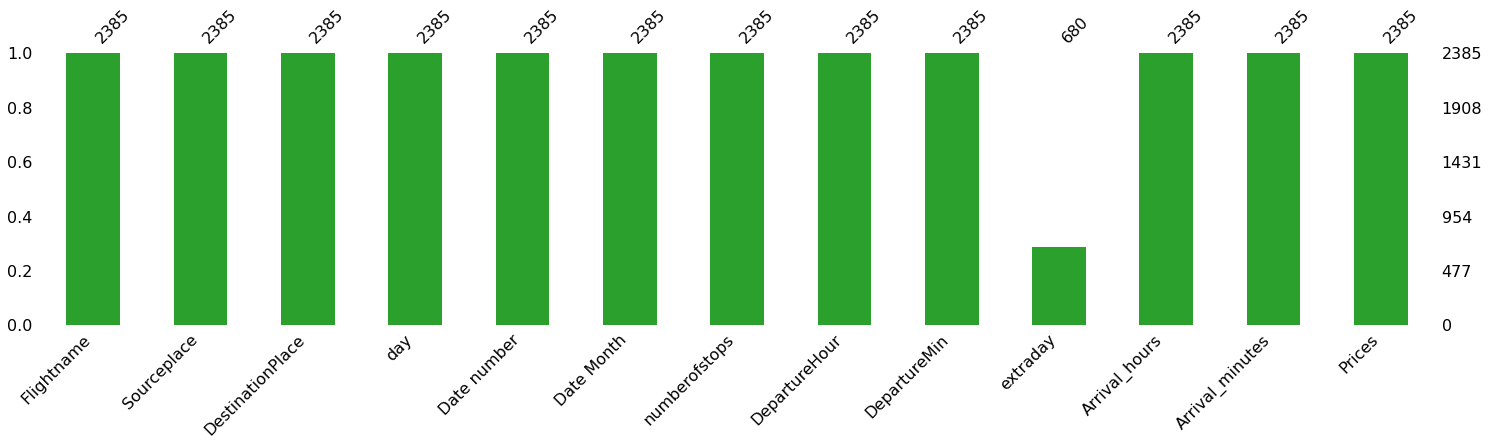

In [49]:
missingno.bar(df, figsize = (25,5), color="tab:green")

In [50]:
print(f"Rows and Columns before dropping duplicates: ", df.shape)
df.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df.shape)

Rows and Columns before dropping duplicates:  (2385, 13)
Rows and Columns after dropping duplicates:  (2385, 13)


In [51]:
#FILLING THE EXTRA DAY null values WITH "no extra day"
df["extraday"].fillna("no extra day",inplace=True)
df["extraday"]

0              1 day
1              1 day
2              1 day
3              1 day
4              1 day
            ...     
2380    no extra day
2381    no extra day
2382    no extra day
2383           1 day
2384    no extra day
Name: extraday, Length: 2385, dtype: object

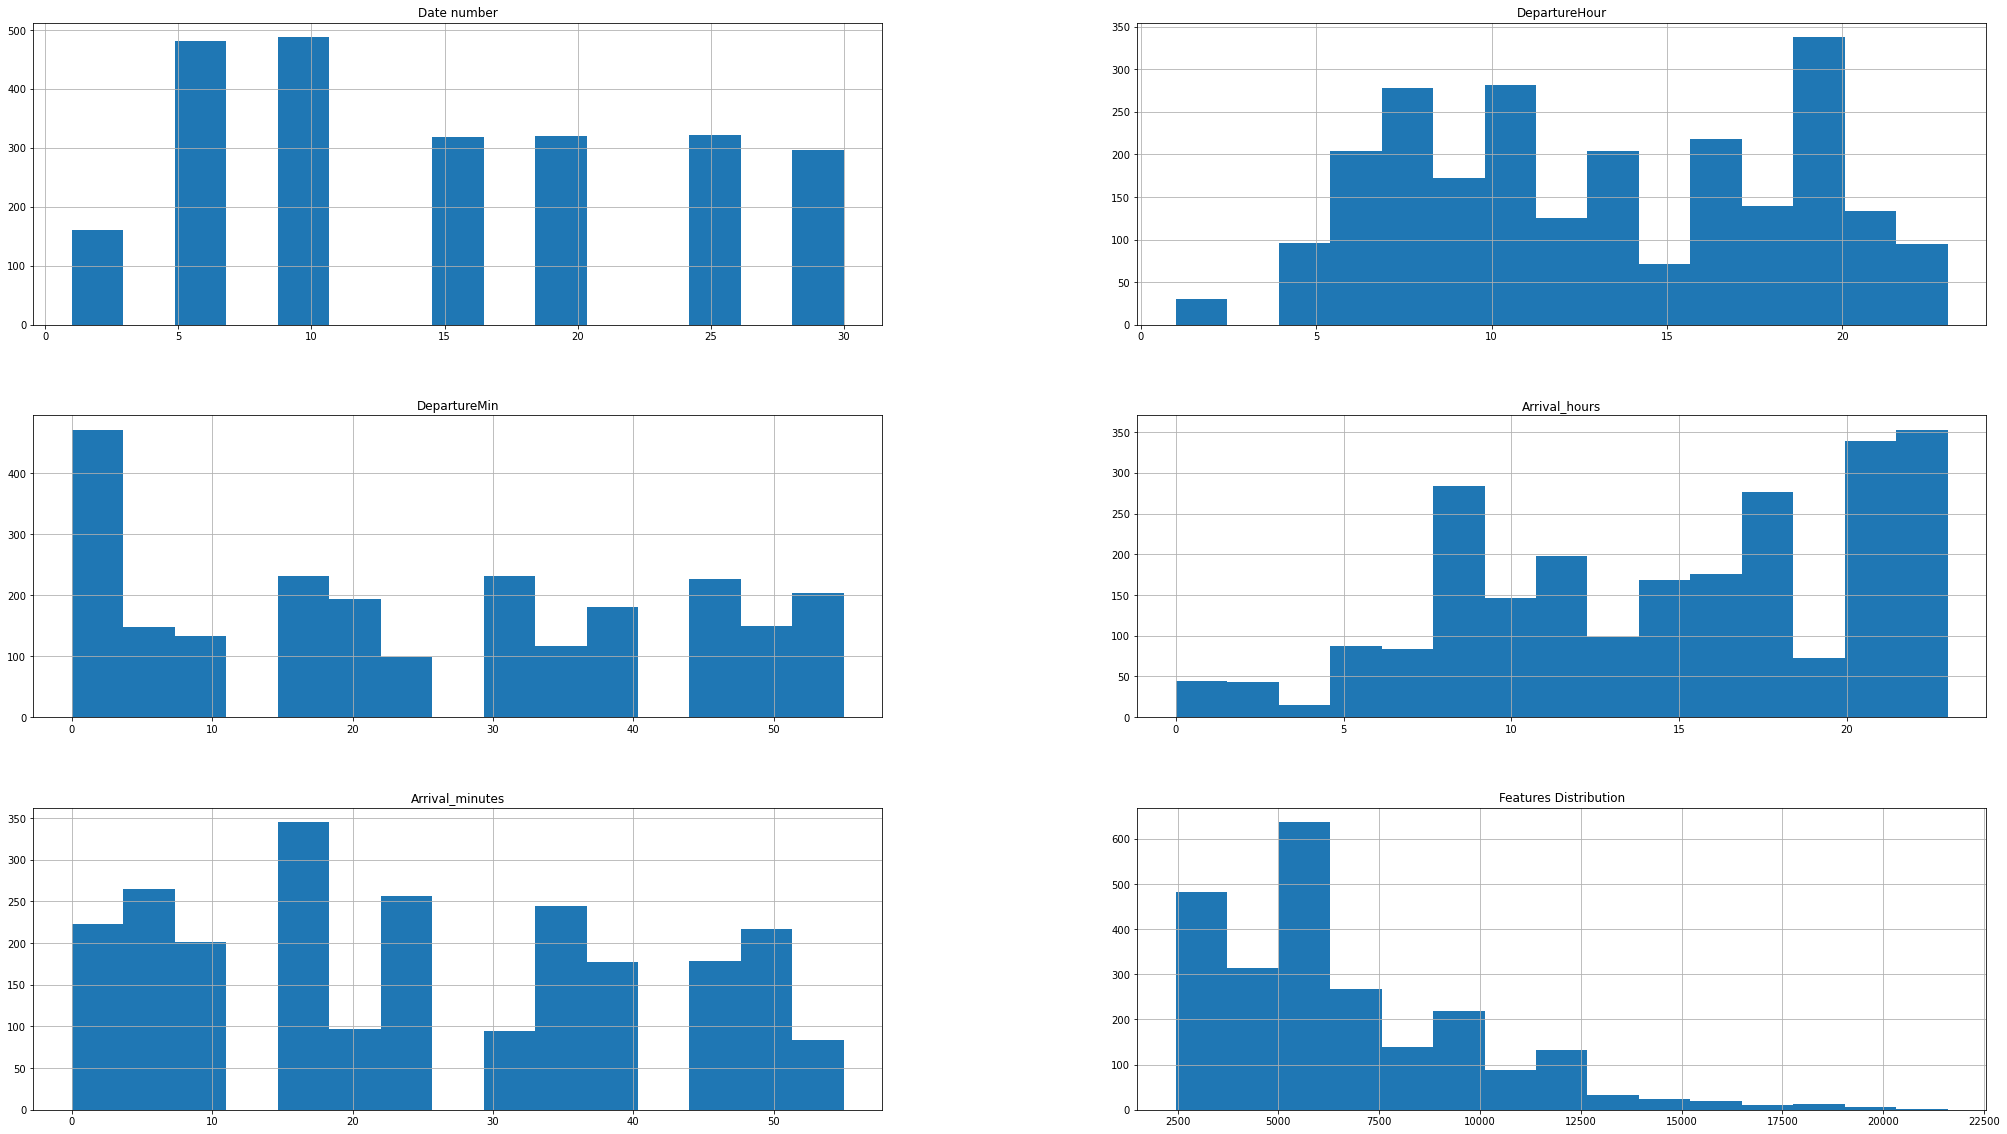

In [52]:
#checking for outliers
df.hist(figsize=(35,20),bins = 15)
plt.title("Features Distribution")
plt.show()

No outliers are present

In [53]:
df.nunique().to_frame("Unique Values")

,Unique Values
Flightname,6
Sourceplace,1
DestinationPlace,1
day,7
Date number,7
Date Month,3
numberofstops,4
DepartureHour,22
DepartureMin,12
extraday,3


In the above cell we can see the list of all the columns and how many unique values they hold.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Flightname        2385 non-null   object
 1   Sourceplace       2385 non-null   object
 2   DestinationPlace  2385 non-null   object
 3   day               2385 non-null   object
 4   Date number       2385 non-null   int64 
 5   Date Month        2385 non-null   object
 6   numberofstops     2385 non-null   object
 7   DepartureHour     2385 non-null   int64 
 8   DepartureMin      2385 non-null   int64 
 9   extraday          2385 non-null   object
 10  Arrival_hours     2385 non-null   int64 
 11  Arrival_minutes   2385 non-null   int64 
 12  Prices            2385 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 260.9+ KB


# Data visualization and analysis

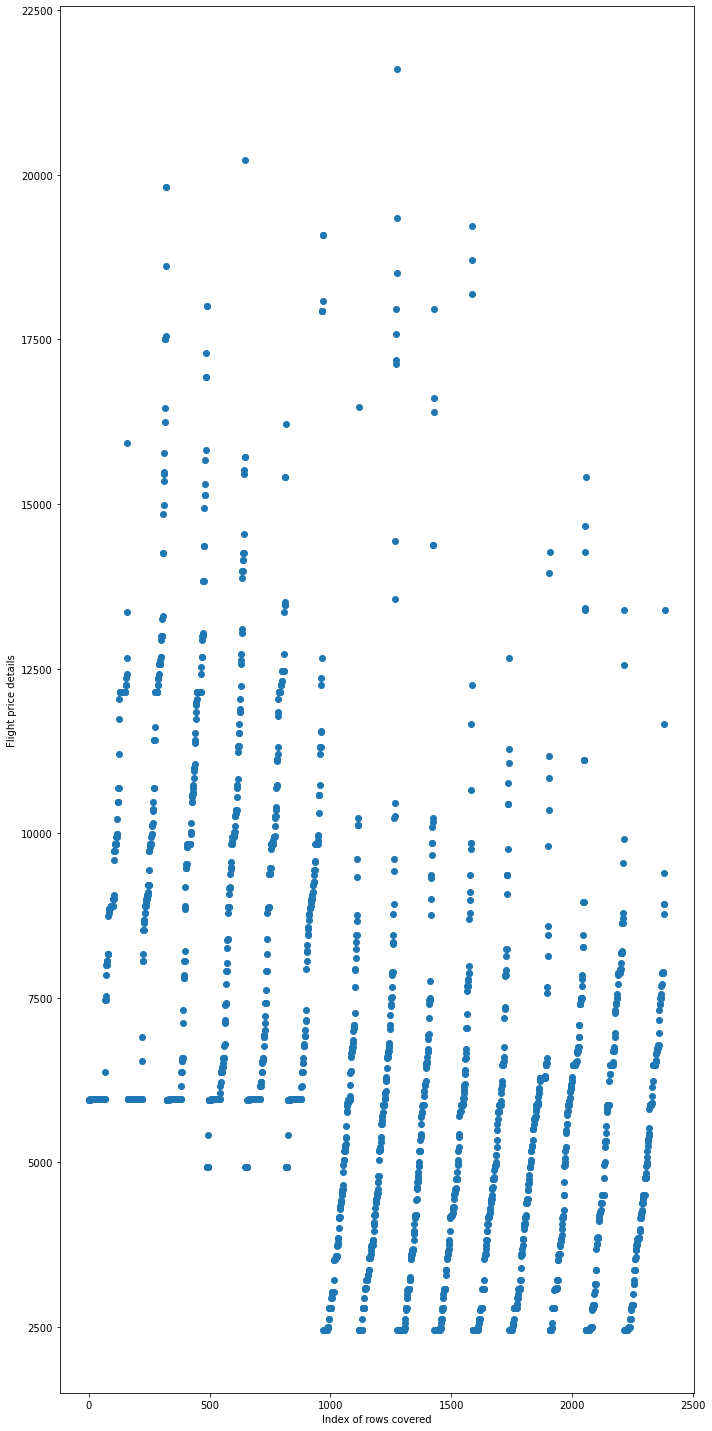

In [55]:
plt.style.use('fast')
plt.figure(figsize=(10,20))
plt.scatter(df.index, df['Prices'])
plt.xlabel("Index of rows covered")
plt.ylabel("Flight price details")
plt.tight_layout()
plt.show()

In the above scatter plot we are able to see that most of the flight price values are accumulated between 2500 and 12500 and very rare data points are distributed abov that number.

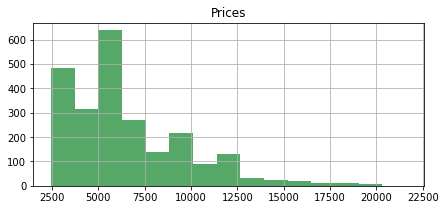

In [56]:
#Prices
df['Prices'].hist(figsize=(7,3),bins = 15,color='g')
plt.title("Prices")
plt.show()

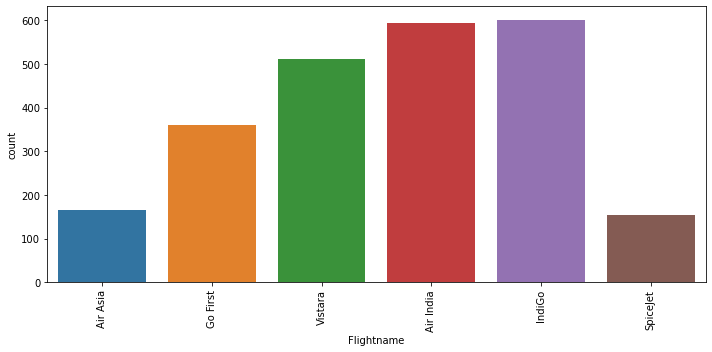

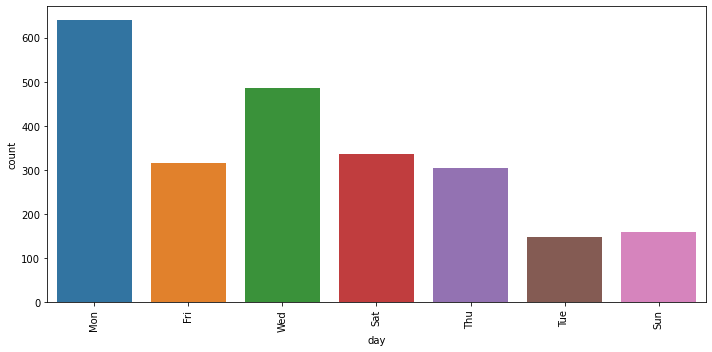

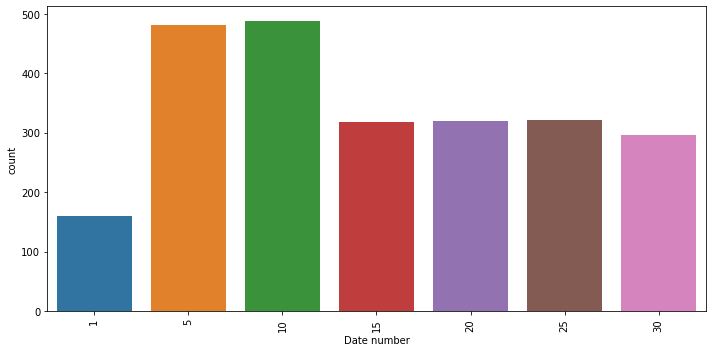

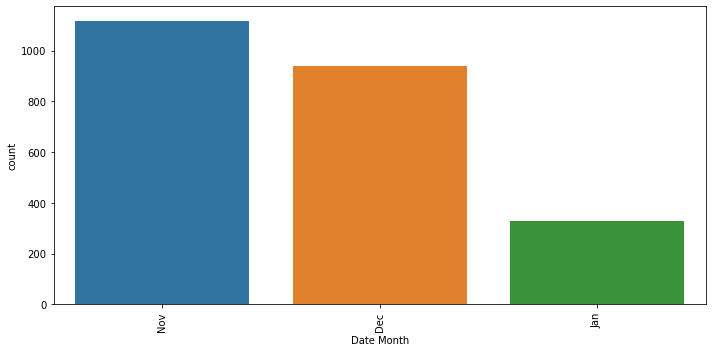

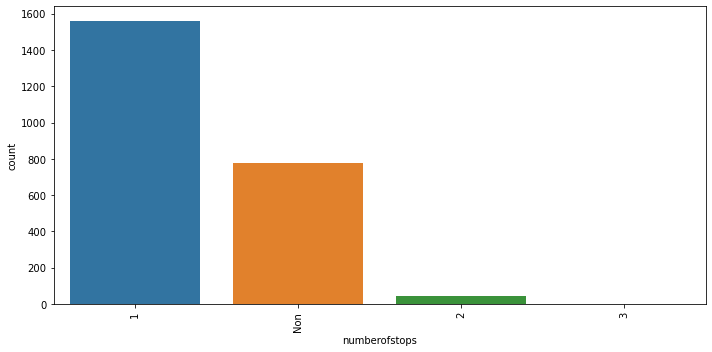

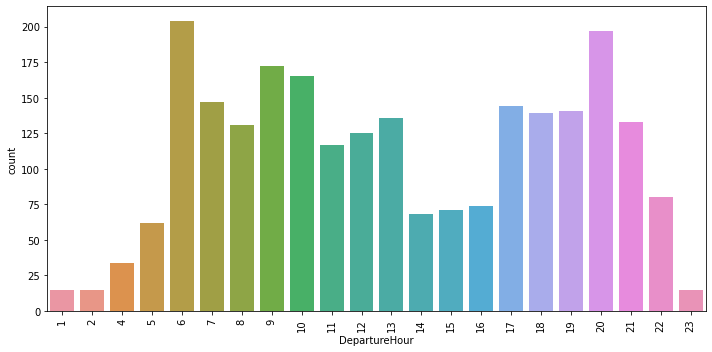

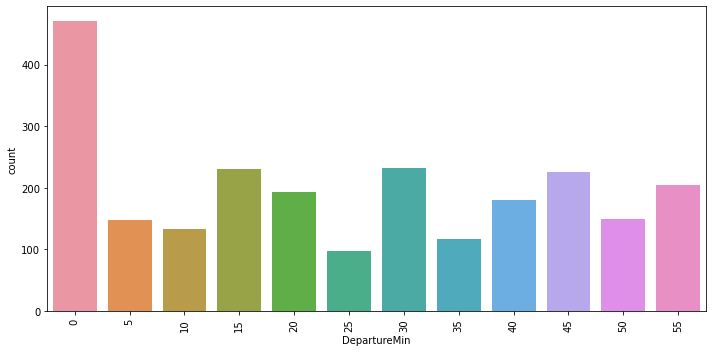

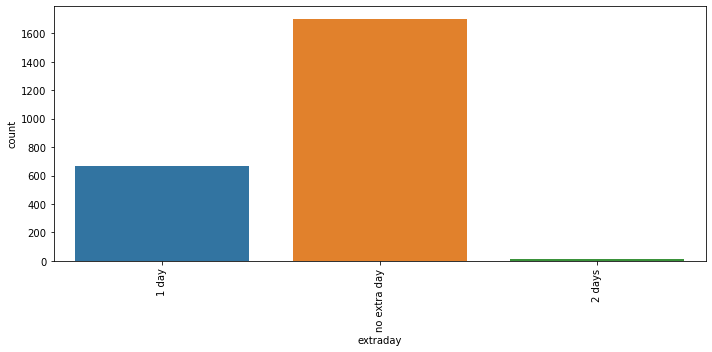

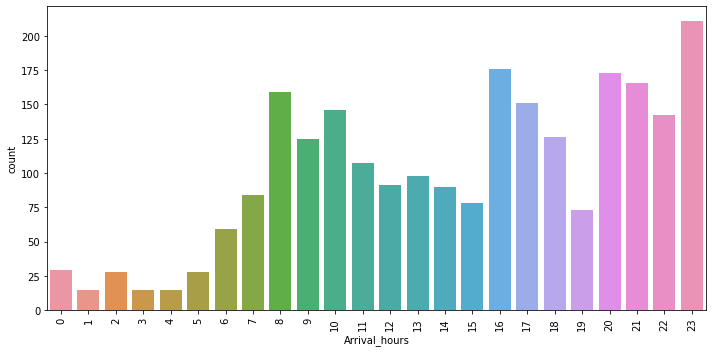

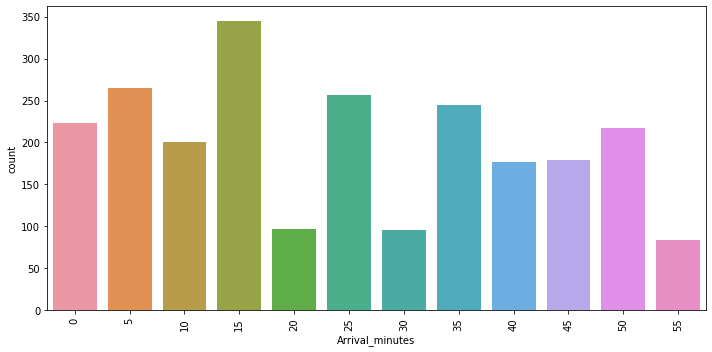

In [57]:
def generate_countplot(x):
    plt.figure(figsize=(10,5))
    sns.countplot(x)
    plt.xticks(rotation=90)
    plt.tight_layout()
    return plt.show()

generate_countplot(df['Flightname'])
generate_countplot(df['day'])
generate_countplot(df['Date number'])
generate_countplot(df['Date Month'])
generate_countplot(df['numberofstops'])
generate_countplot(df['DepartureHour'])
generate_countplot(df['DepartureMin'])
generate_countplot(df['extraday'])
generate_countplot(df['Arrival_hours'])
generate_countplot(df['Arrival_minutes'])

Analysis from Graphs:

1.Maximum number of flights are of Air India and Indigo

2.Maximum number of flights are taken on Monday

3.1 stop is more than no stop flights

4.Maximum flights take off between 6am-10am and 5pm to 9pm

5.Many flights take one extra day to reach the destination

6.Most of the flights arrive between 8am to 10am and 4pm to 11pm



<AxesSubplot:xlabel='Date number', ylabel='Prices'>

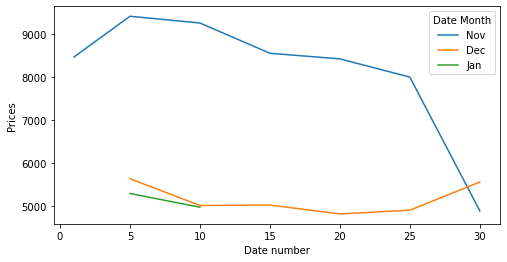

In [58]:
plt.figure(figsize=(8,4))
sns.lineplot(x='Date number', y='Prices', hue='Date Month', data=df, ci=None)

Data collected are of November, December and January months. 

Prices are seen to be higher till November 25th, the data was collected on october 30th. It shows a 30ay gap will cause the price to fall

There shows to be a steep fall in prices after 30 days.

Prices are seen to be decrementing in small intervals till 30days and in steep interval after 30days

Prices are also seen to be increasing as we book near to the departure date

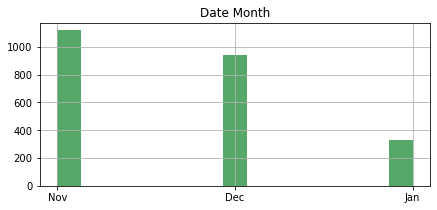

<AxesSubplot:xlabel='Flightname', ylabel='Prices'>

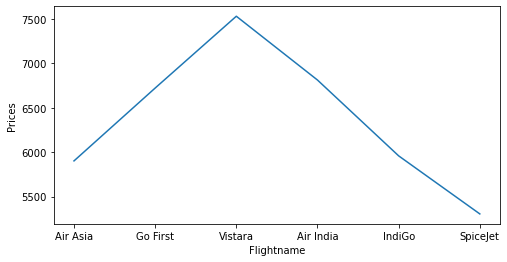

In [59]:
#Months
df['Date Month'].hist(figsize=(7,3),bins = 15,color='g')
plt.title("Date Month")
plt.show()

plt.figure(figsize=(8,4))
sns.lineplot(x='Flightname', y='Prices', data=df, ci=None)

Vistara shows having the highest price

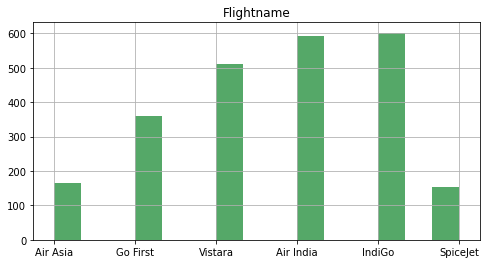

<AxesSubplot:xlabel='Arrival_hours', ylabel='Prices'>

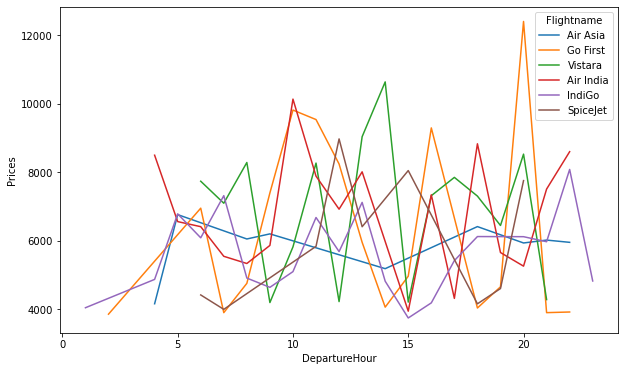

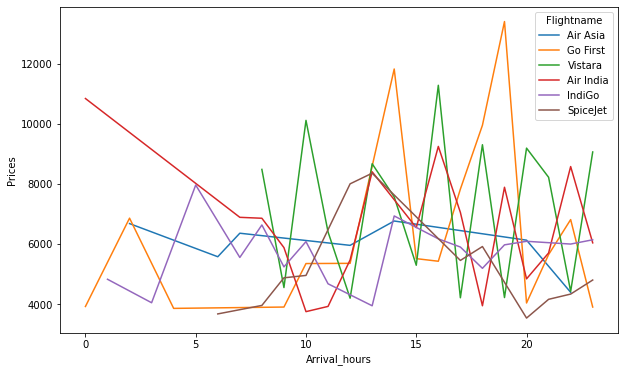

In [60]:
#Airline
df['Flightname'].hist(figsize=(8,4),bins = 15,color='g')
plt.title("Flightname")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x='DepartureHour', y='Prices', hue='Flightname', data=df, ci=None)

plt.figure(figsize=(10,6))
sns.lineplot(x='Arrival_hours', y='Prices', hue='Flightname', data=df, ci=None)

Maximum number of flights are of Air India and Indigo

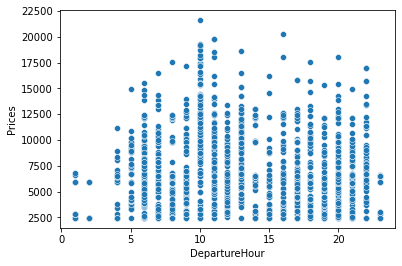

In [61]:
#check the relation between Departure_time and Price
sns.scatterplot(x='DepartureHour',y='Prices',data=df)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

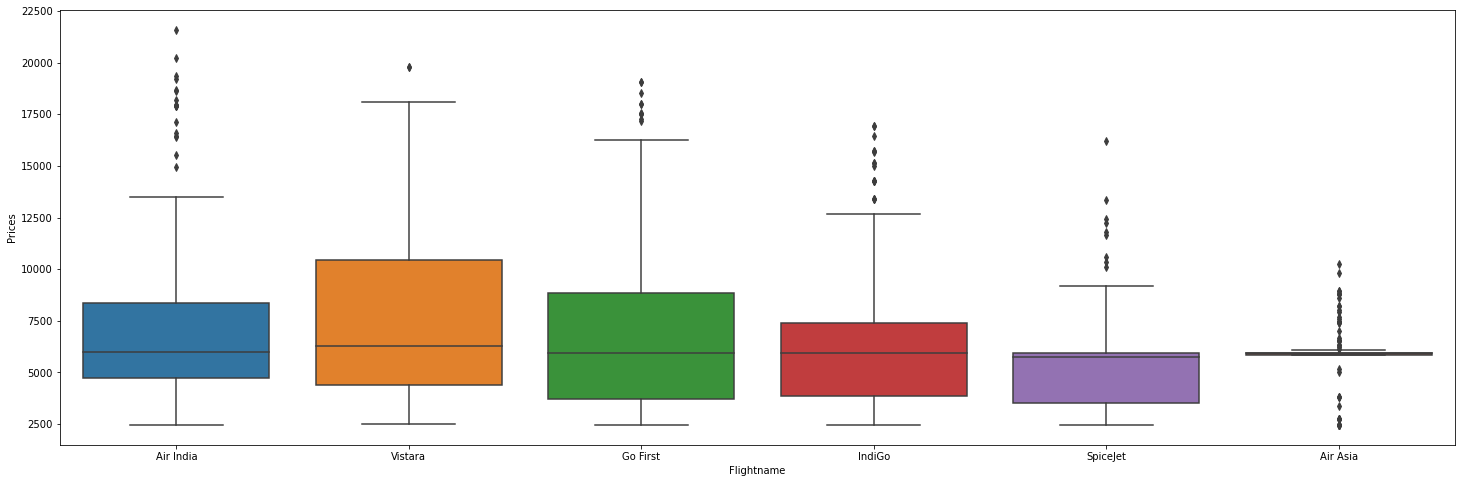

In [62]:
# Airine vs price
plt.figure(figsize=(25,8))
sns.boxplot(y='Prices',x='Flightname',data= df.sort_values('Prices',ascending=False))
plt.show

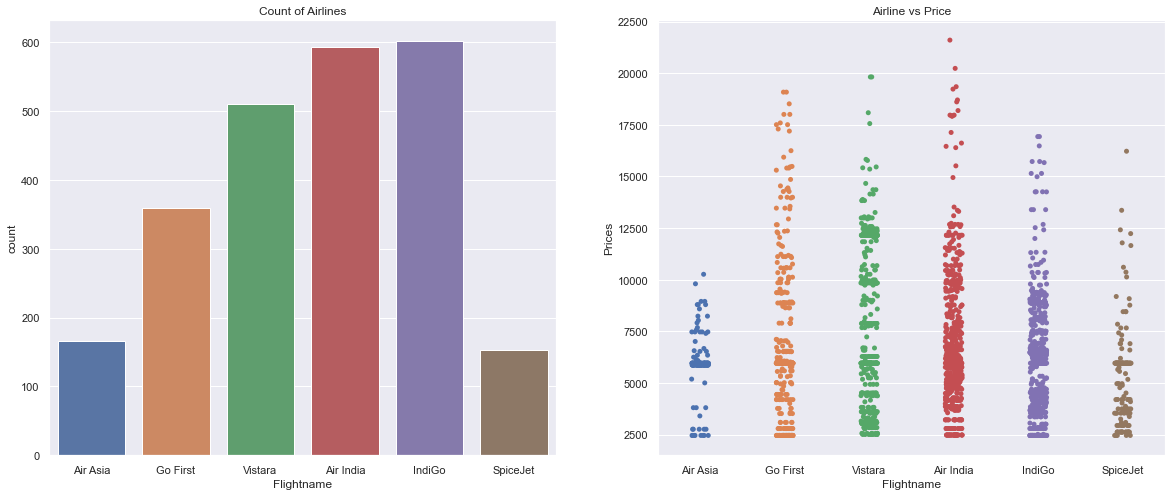

In [63]:
#lets check the count of airlines and check the relation between airline and Price
sns.set_theme()
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.countplot(df.Flightname)
plt.title('Count of Airlines')

plt.subplot(1,2,2)
sns.stripplot(x='Flightname',y='Prices', data=df)
plt.title('Airline vs Price')

plt.show()

<AxesSubplot:xlabel='Date number', ylabel='Prices'>

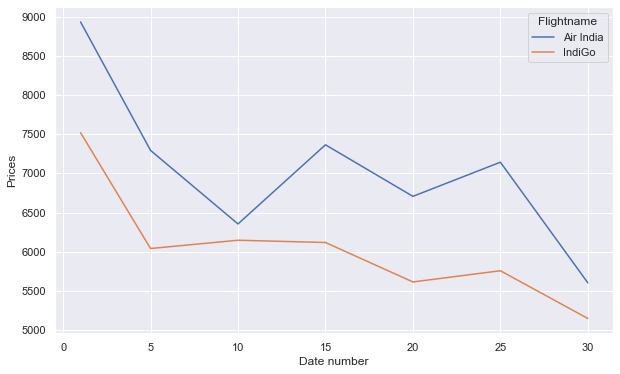

In [64]:
a=["IndiGo","Air India"]
filterinfDataframe = df[(df['Flightname'].isin(a)) & (df['Flightname'].isin(a)) ]
filterinfDataframe


plt.figure(figsize=(10,6))
sns.lineplot(x='Date number', y='Prices', hue='Flightname', data=filterinfDataframe, ci=None)

<function matplotlib.pyplot.show(close=None, block=None)>

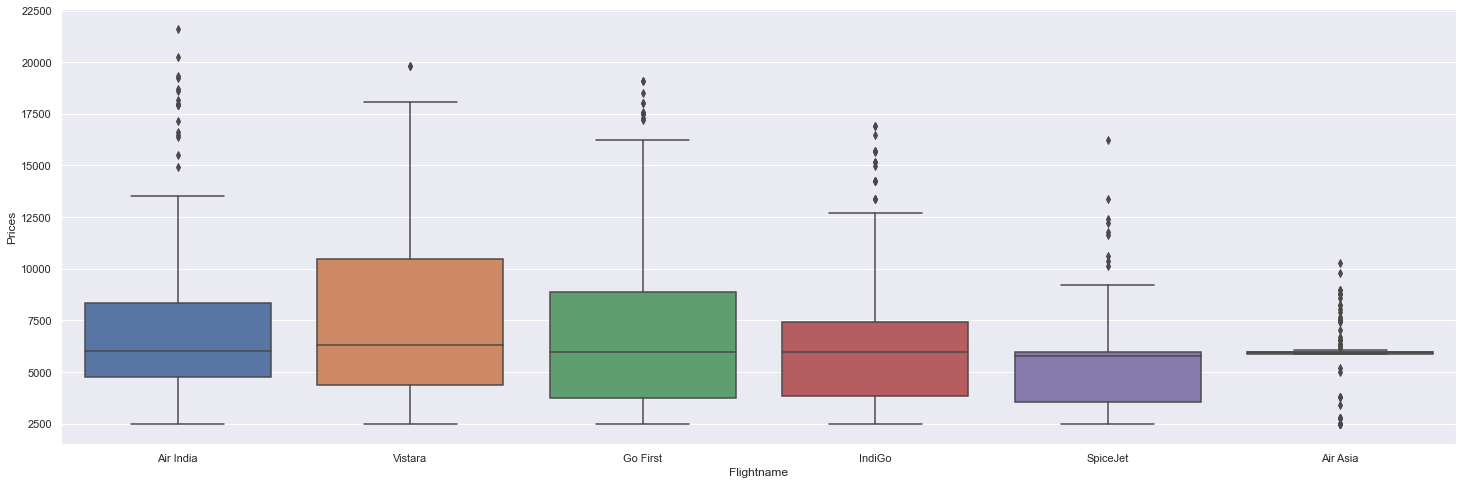

In [66]:
# Airine vs price
plt.figure(figsize=(25,8))
sns.boxplot(y='Prices',x='Flightname',data= df.sort_values('Prices',ascending=False))
plt.show

Indigo flights are cheaper than AirIndia

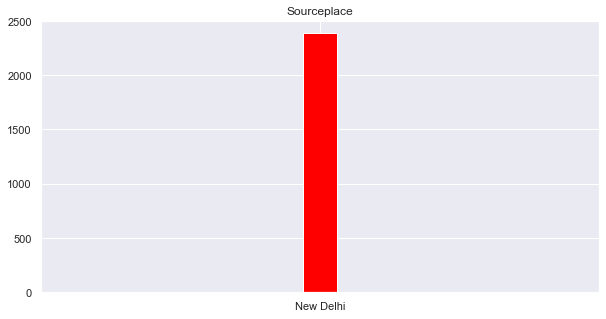

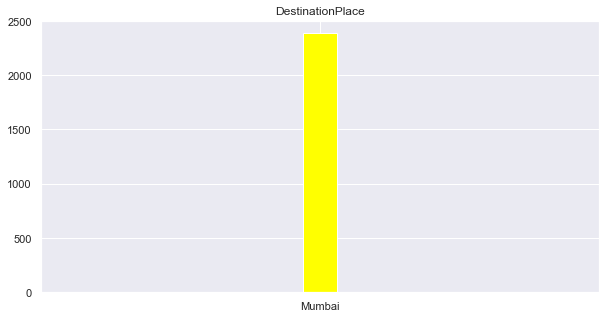

In [67]:
#Source
df['Sourceplace'].hist(figsize=(10,5),bins = 15,color='red')
plt.title("Sourceplace")
plt.show()

#Destination
df['DestinationPlace'].hist(figsize=(10,5),bins = 15,color='yellow')
plt.title("DestinationPlace")
plt.show()

we have considered only data between NewDelhi and Mumbai

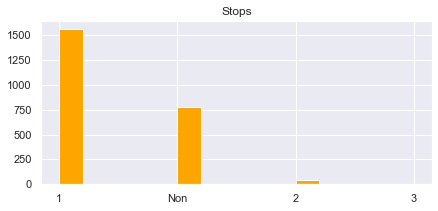

<AxesSubplot:xlabel='numberofstops', ylabel='Prices'>

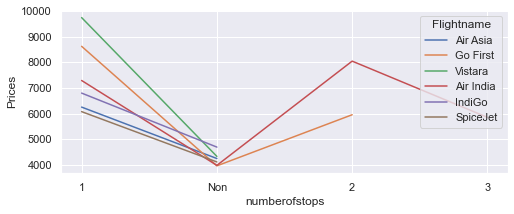

In [68]:
#Total_Stops
df['numberofstops'].hist(figsize=(7,3),bins = 15,color='orange')
plt.title("Stops")
plt.show()

plt.figure(figsize=(8,3))
sns.lineplot(x='numberofstops', y='Prices', hue='Flightname', data=df, ci=None)




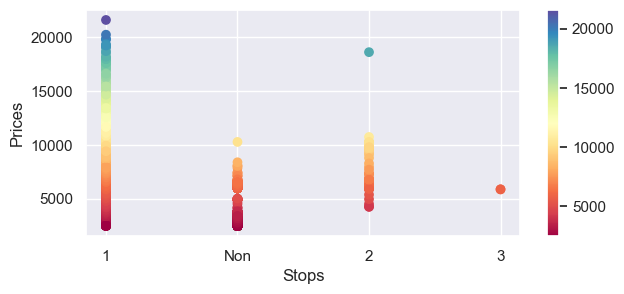

In [69]:
x =df["numberofstops"] 
y =df["Prices"]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':100})
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.xlabel('Stops')
plt.ylabel('Prices')
plt.show()

Highest number of flights have 1 stop 

The maximum sale prices are seen for 1 stop and lesser for non stop

Maximum flights have 1 stop and minimum flights have 3 stops

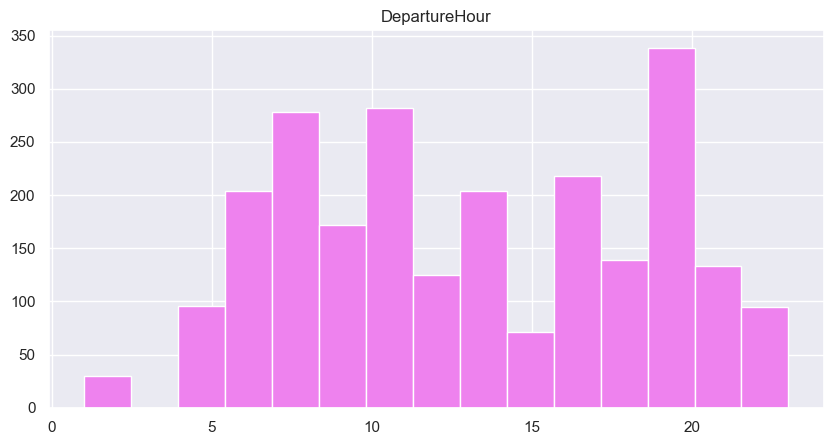

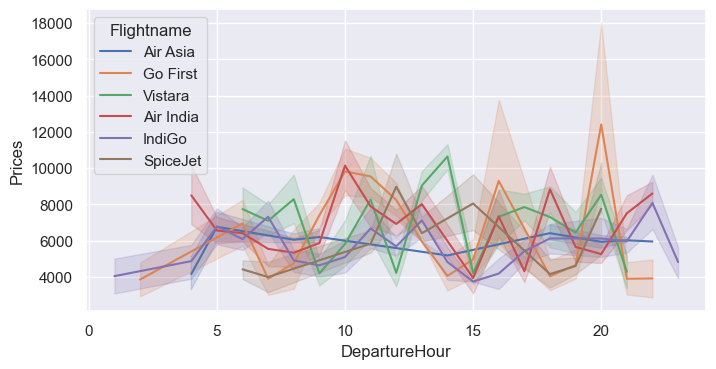

In [70]:
#day
df['DepartureHour'].hist(figsize=(10,5),bins = 15,color='violet')
plt.title("DepartureHour")
plt.show()

plt.figure(figsize=(8,4))
sns.lineplot(x="DepartureHour",y="Prices",hue="Flightname",data=df)
plt.show()


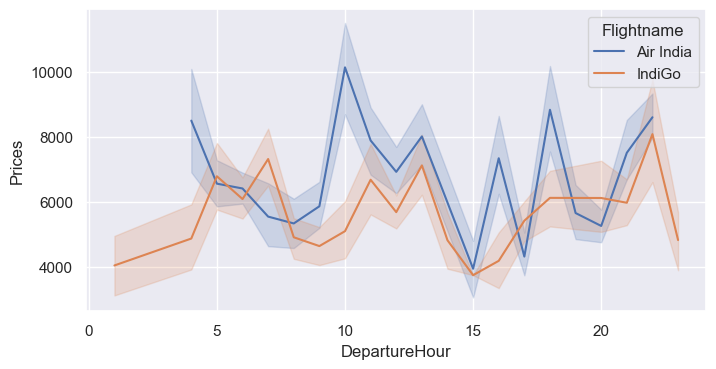

In [71]:
plt.figure(figsize=(8,4))
sns.lineplot(x="DepartureHour",y="Prices",hue="Flightname",data=filterinfDataframe)
plt.show()

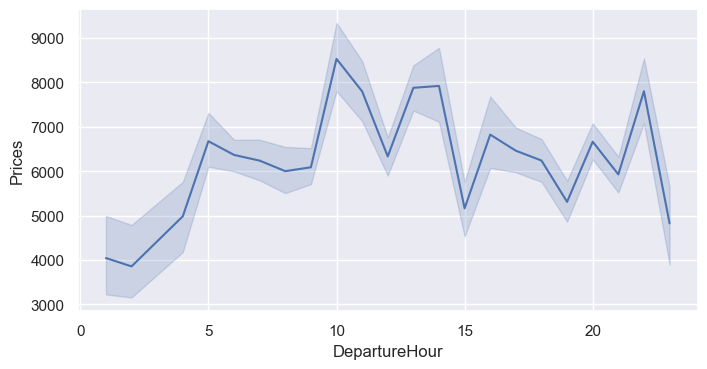

In [72]:
plt.figure(figsize=(8,4))
sns.lineplot(x="DepartureHour",y="Prices",data=df)
plt.show()

Prices are lower in the morning than in the afternoon and evenings

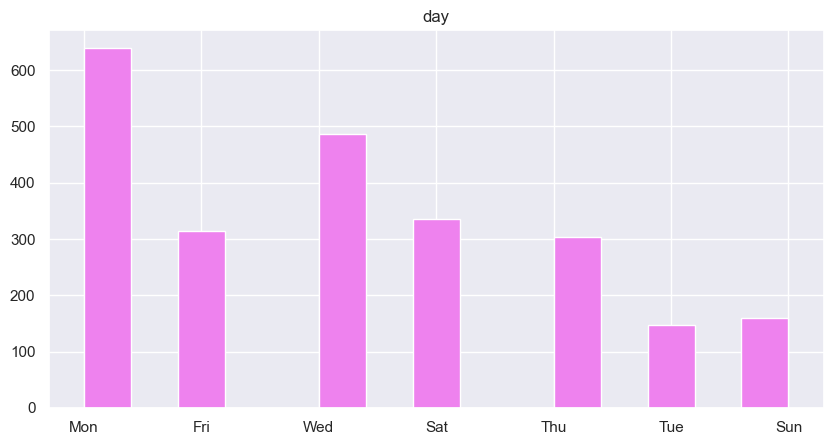

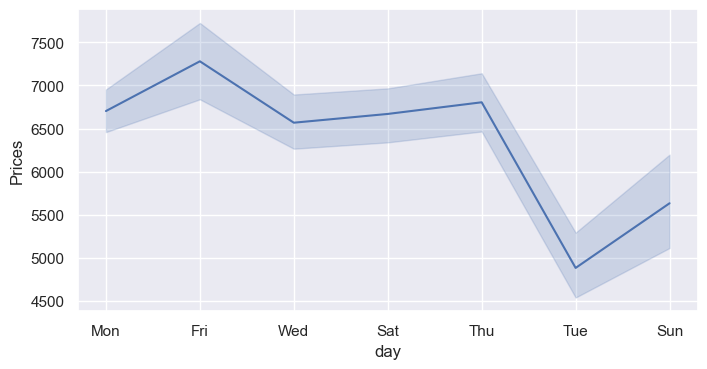

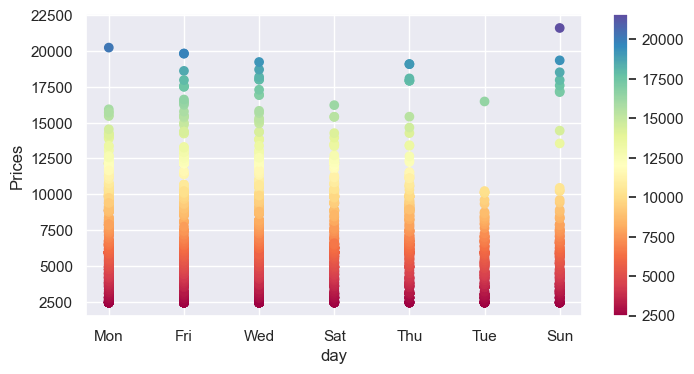

In [73]:
#day
df['day'].hist(figsize=(10,5),bins = 15,color='violet')
plt.title("day")
plt.show()

plt.figure(figsize=(8,4))
sns.lineplot(x="day",y="Prices",data=df)
plt.show()

x =df["day"] 
y =df["Prices"]
 
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':100})
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.xlabel('day')
plt.ylabel('Prices')
plt.show()

1.Maximum flights are taken on monday

2.Highest prices is for Fridays,wednesdays and sundays

<Figure size 2000x800 with 0 Axes>

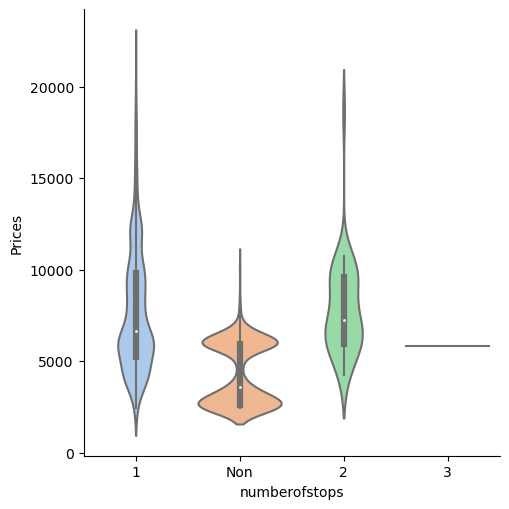

In [74]:
#lets check the relation between fuel_type, Gear_transmission and Mileage 
plt.figure(figsize=(20,8))
plt.style.use('default')
sns.catplot(x="numberofstops", y="Prices",
            kind="violin", split=True,
            palette="pastel", data=df)
plt.show()

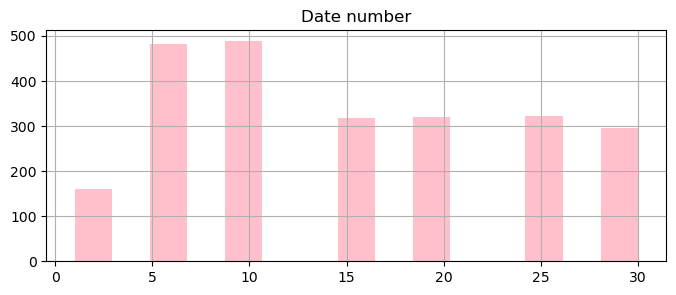

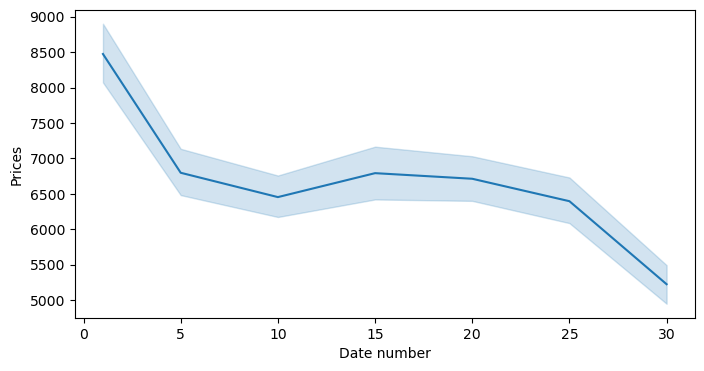

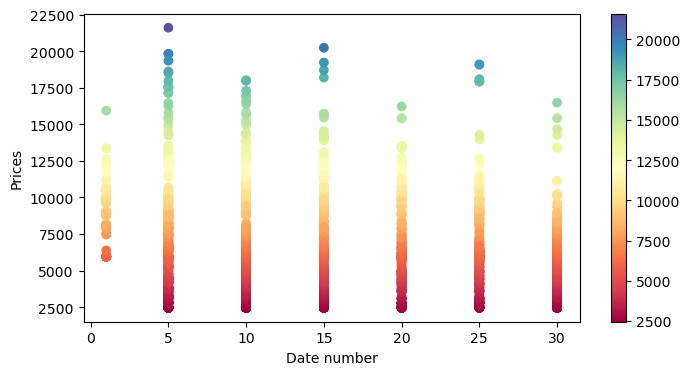

In [75]:
#Date number
df['Date number'].hist(figsize=(8,3),bins = 15,color='pink')
plt.title("Date number")
plt.show()

plt.figure(figsize=(8,4))
sns.lineplot(x="Date number",y="Prices",data=df)
plt.show()

x =df["Date number"] 
y =df["Prices"]

plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':100})
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.xlabel('Date number')
plt.ylabel('Prices')
plt.show()

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Flightname        2385 non-null   object
 1   Sourceplace       2385 non-null   object
 2   DestinationPlace  2385 non-null   object
 3   day               2385 non-null   object
 4   Date number       2385 non-null   int64 
 5   Date Month        2385 non-null   object
 6   numberofstops     2385 non-null   object
 7   DepartureHour     2385 non-null   int64 
 8   DepartureMin      2385 non-null   int64 
 9   extraday          2385 non-null   object
 10  Arrival_hours     2385 non-null   int64 
 11  Arrival_minutes   2385 non-null   int64 
 12  Prices            2385 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 340.9+ KB


In [77]:
#Dealing with categorical data
oe=OrdinalEncoder()
def ordinal_encoder(df, col):
    df[col]=oe.fit_transform(df[col])
    return df

df=ordinal_encoder(df,['Flightname', 'Sourceplace', 'DestinationPlace', 'Date Month', 'numberofstops','extraday','day'])


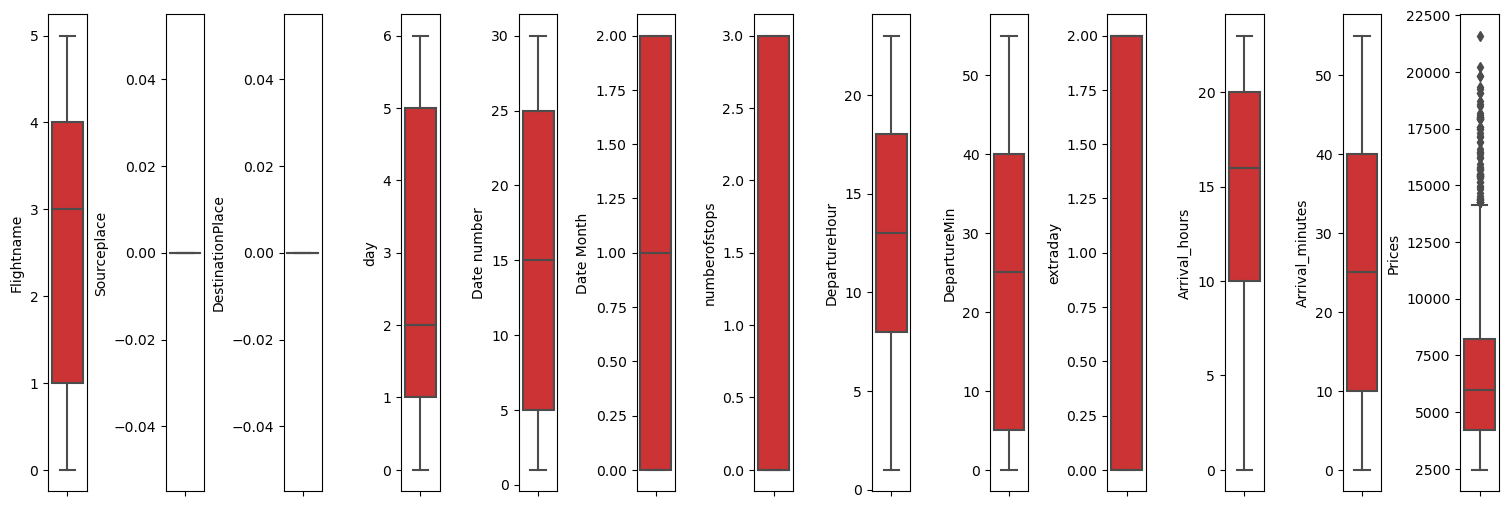

In [78]:

#box plots of categorical datas
plt.style.use('seaborn-dark-palette')
fig, ax = plt.subplots(ncols=13, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df.items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="Set1")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

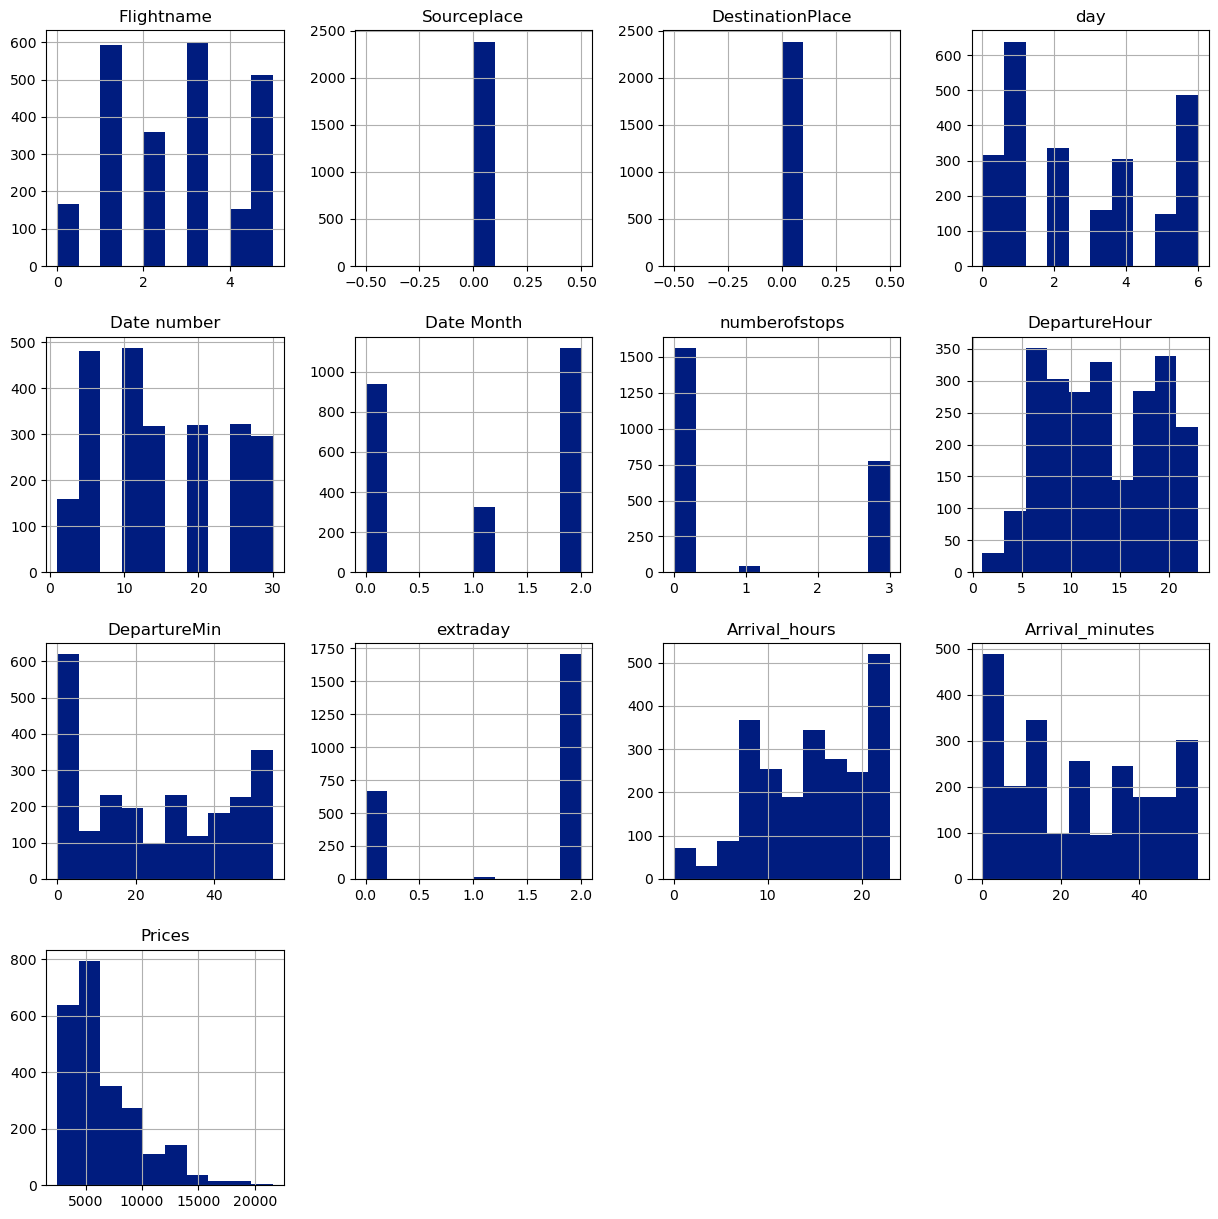

In [79]:
plt.style.use('seaborn-dark-palette')
df.hist(figsize=(15,15))
plt.show()

# Exploratory Data Analysis

In [80]:
#checking null values again
df.isnull().sum()

Flightname          0
Sourceplace         0
DestinationPlace    0
day                 0
Date number         0
Date Month          0
numberofstops       0
DepartureHour       0
DepartureMin        0
extraday            0
Arrival_hours       0
Arrival_minutes     0
Prices              0
dtype: int64

<AxesSubplot:>

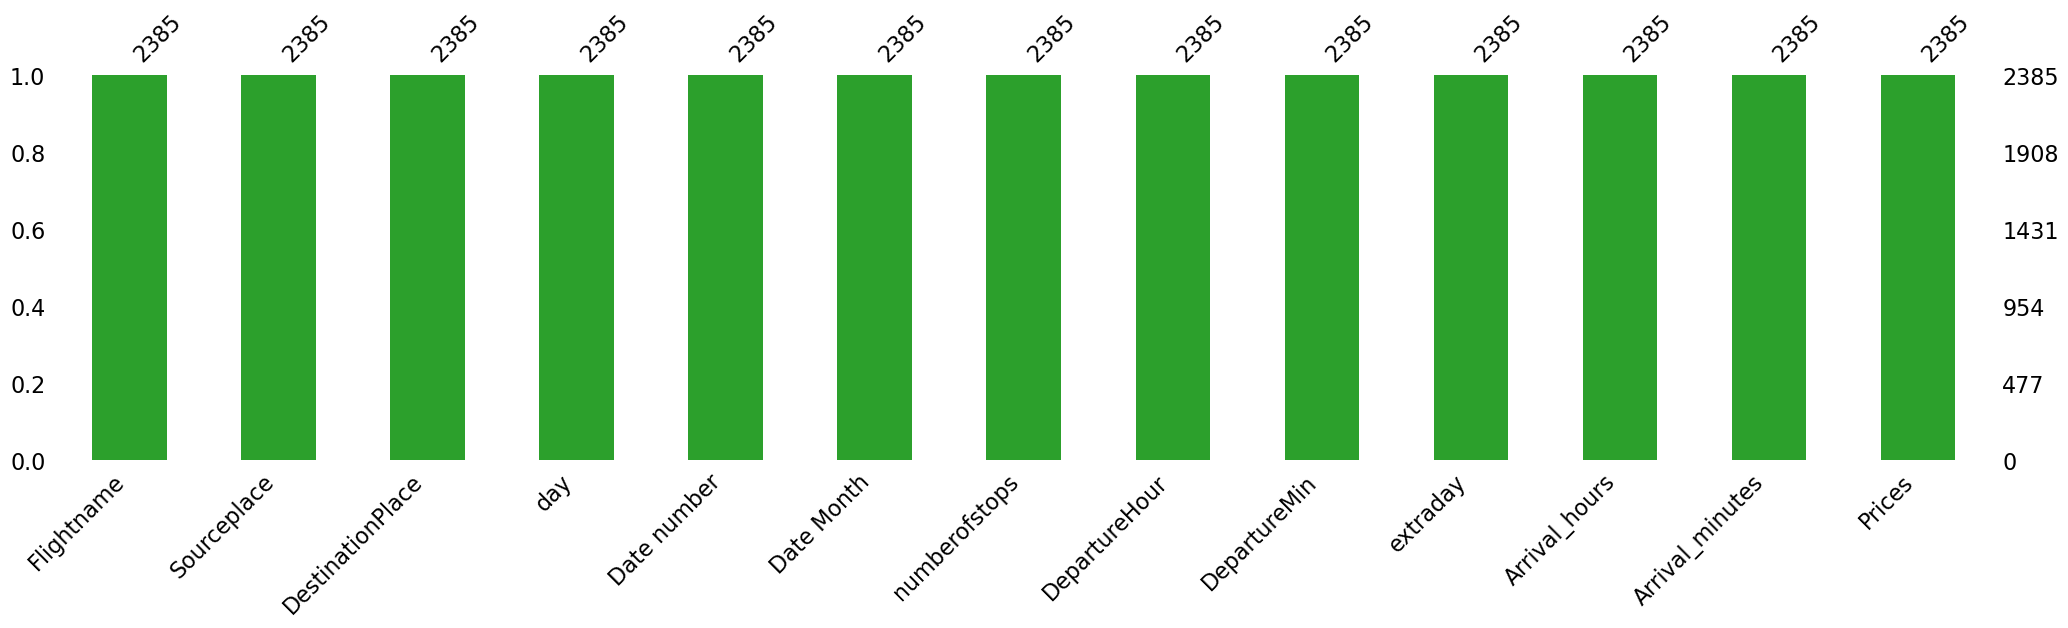

In [81]:
missingno.bar(df, figsize = (25,5), color="tab:green")

In [82]:
df

,Flightname,Sourceplace,DestinationPlace,day,Date number,Date Month,numberofstops,DepartureHour,DepartureMin,extraday,Arrival_hours,Arrival_minutes,Prices
0,0.0,0.0,0.0,1.0,1,2.0,0.0,21,25,0.0,6,45,5953
1,0.0,0.0,0.0,1.0,1,2.0,0.0,21,25,0.0,7,15,5953
2,0.0,0.0,0.0,1.0,1,2.0,0.0,18,35,0.0,6,45,5953
3,0.0,0.0,0.0,1.0,1,2.0,0.0,18,35,0.0,7,15,5953
4,0.0,0.0,0.0,1.0,1,2.0,0.0,22,10,0.0,12,25,5953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,2.0,0.0,0.0,1.0,10,1.0,0.0,12,20,2.0,18,10,8921
2381,2.0,0.0,0.0,1.0,10,1.0,0.0,9,15,2.0,18,10,8921
2382,2.0,0.0,0.0,1.0,10,1.0,0.0,11,50,2.0,18,10,9399
2383,1.0,0.0,0.0,1.0,10,1.0,0.0,10,55,0.0,0,10,11661


In [83]:
print(f"Rows and Columns before dropping duplicates: ", df.shape)
df.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df.shape)

Rows and Columns before dropping duplicates:  (2385, 13)
Rows and Columns after dropping duplicates:  (2385, 13)


In [84]:
#FILLING THE EXTRA DAY null values WITH "no extra day"
df["extraday"].fillna("no extra day",inplace=True)
df["extraday"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2380    2.0
2381    2.0
2382    2.0
2383    0.0
2384    2.0
Name: extraday, Length: 2385, dtype: float64

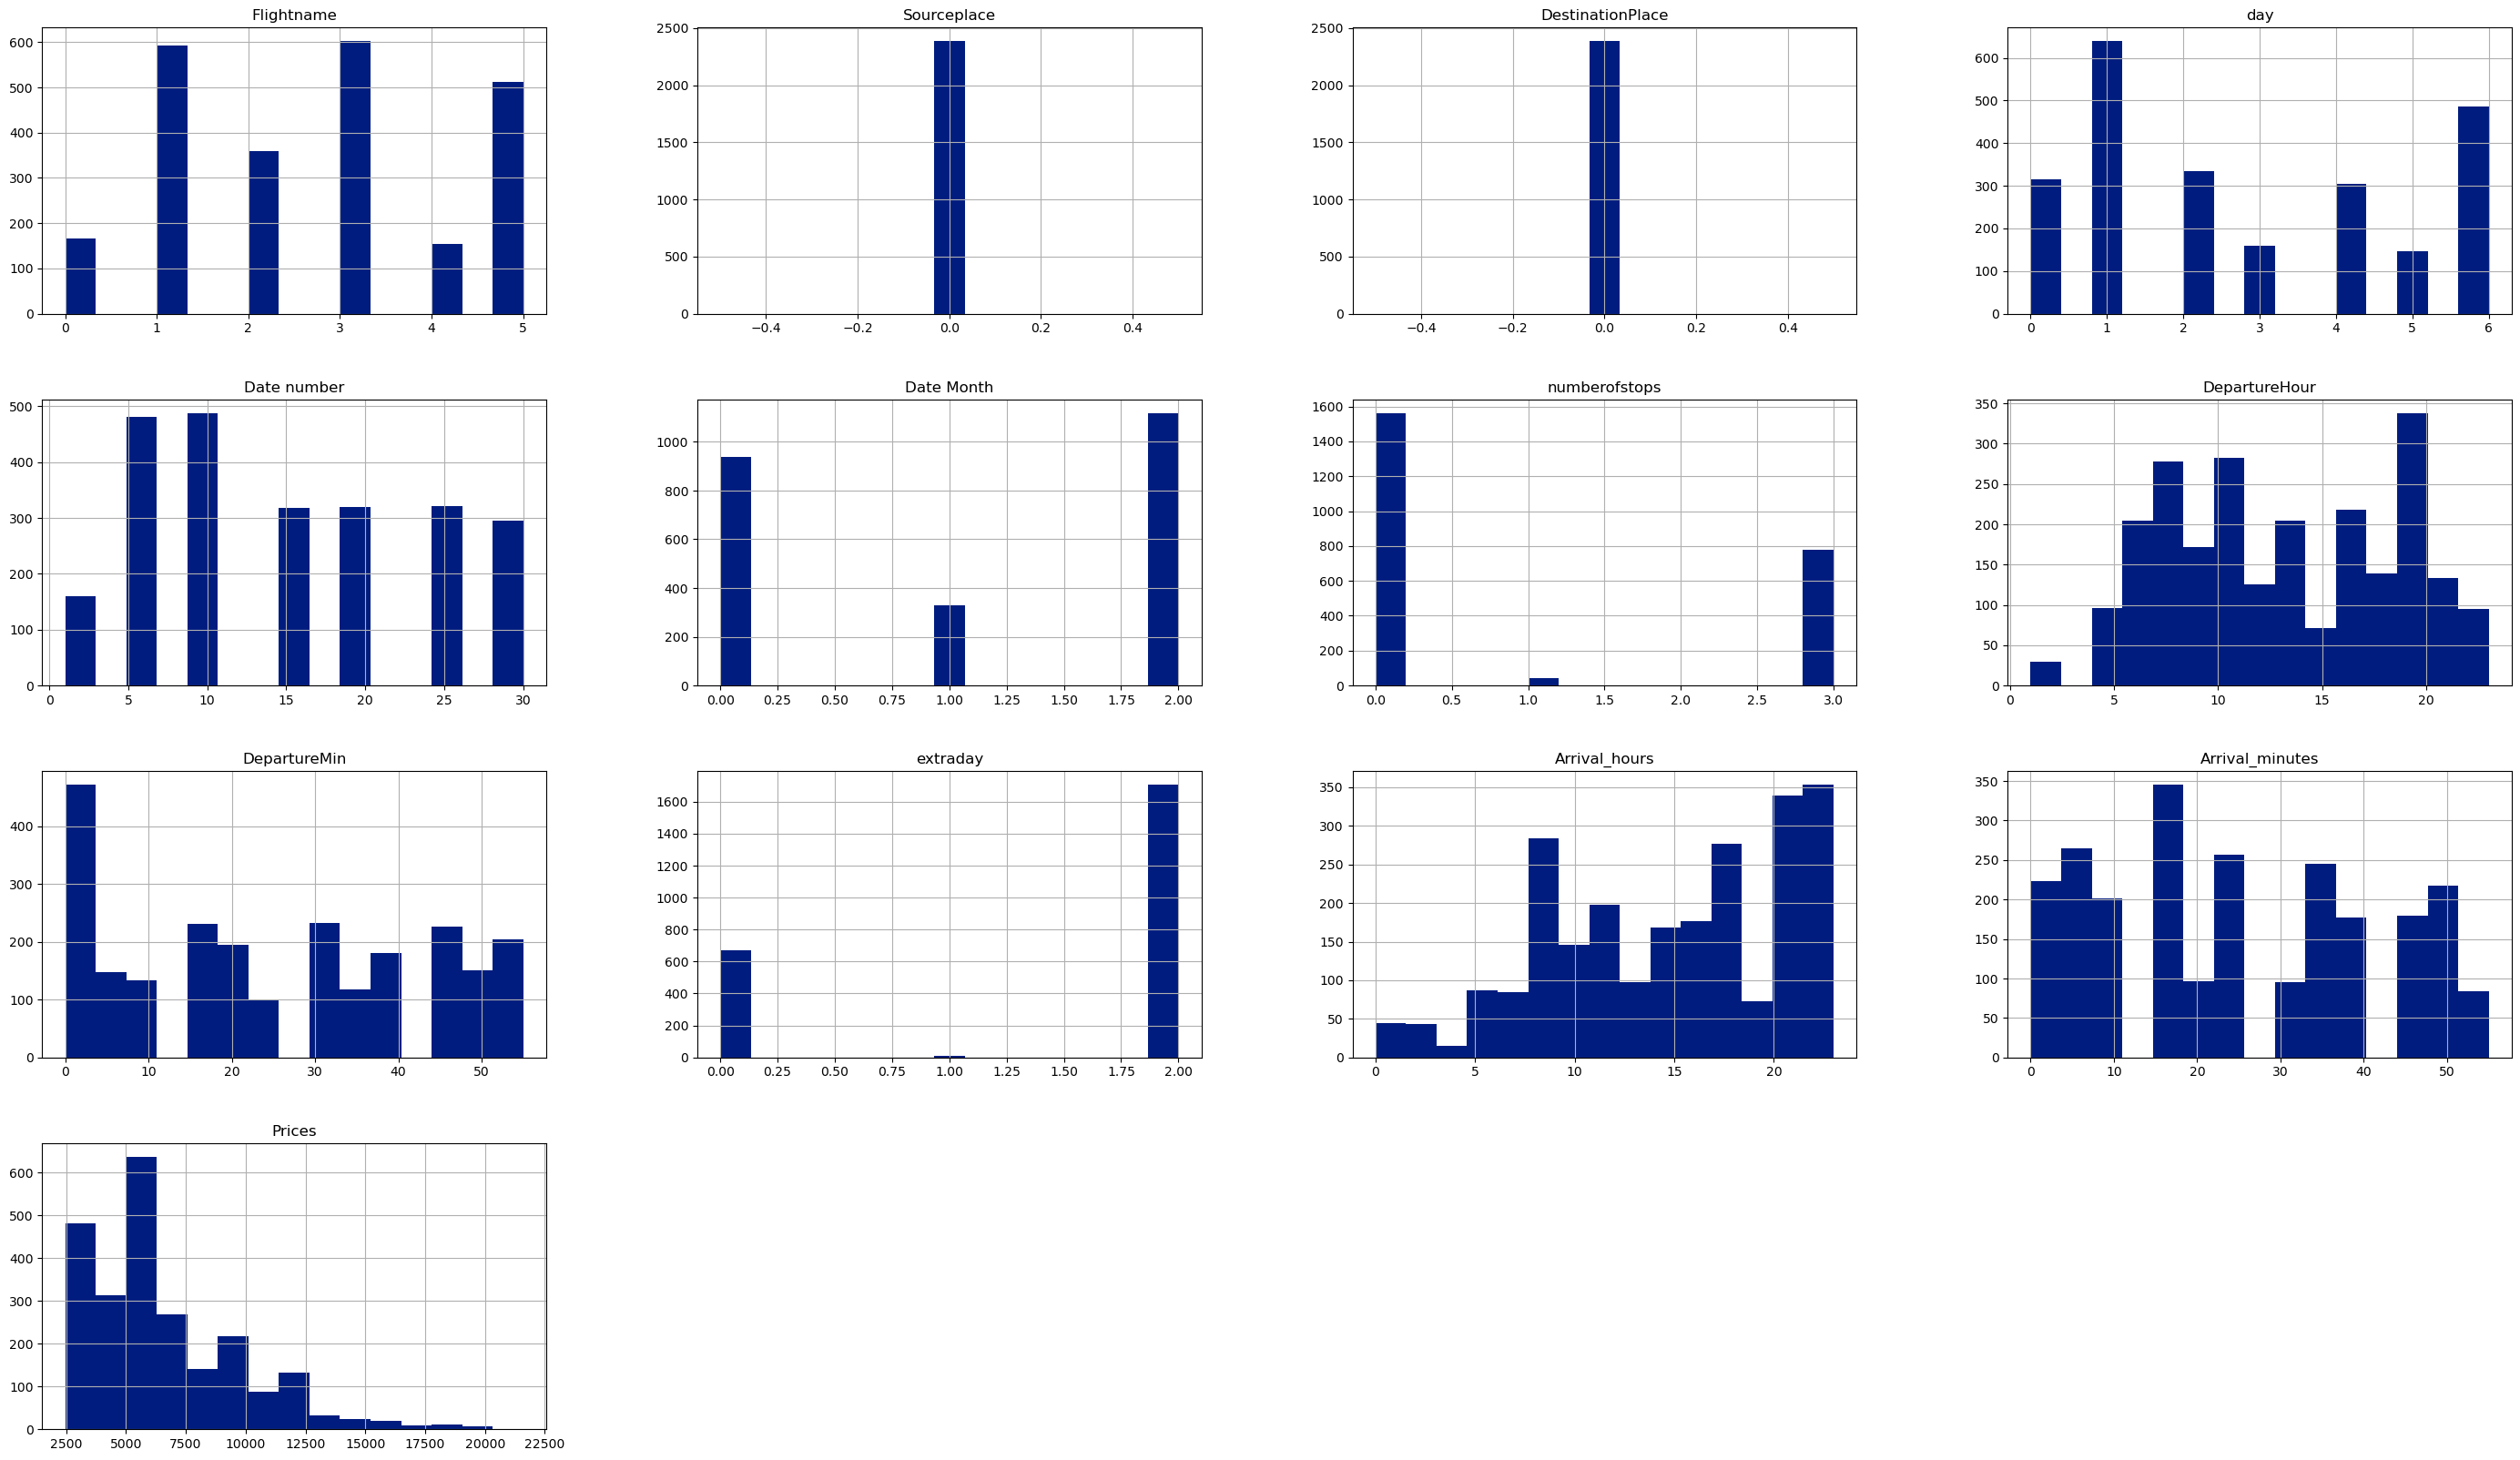

In [85]:
#checking for outliers
df.hist(figsize=(35,20),bins = 15)
plt.title("Features Distribution")
plt.show()

Outliers not present

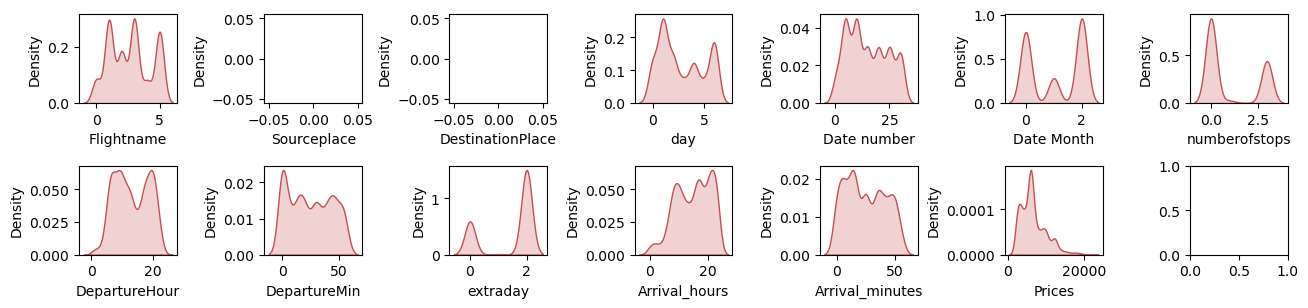

In [86]:
fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(13,3))
index = 0
ax = ax.flatten()
for col, value in df.items():
    sns.distplot(value, ax=ax[index], hist=False, color="r", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

In [87]:
df.nunique().to_frame("Unique Values")

,Unique Values
Flightname,6
Sourceplace,1
DestinationPlace,1
day,7
Date number,7
Date Month,3
numberofstops,4
DepartureHour,22
DepartureMin,12
extraday,3


In the above cell we can see the list of all the columns and how many unique values they hold.

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Flightname        2385 non-null   float64
 1   Sourceplace       2385 non-null   float64
 2   DestinationPlace  2385 non-null   float64
 3   day               2385 non-null   float64
 4   Date number       2385 non-null   int64  
 5   Date Month        2385 non-null   float64
 6   numberofstops     2385 non-null   float64
 7   DepartureHour     2385 non-null   int64  
 8   DepartureMin      2385 non-null   int64  
 9   extraday          2385 non-null   float64
 10  Arrival_hours     2385 non-null   int64  
 11  Arrival_minutes   2385 non-null   int64  
 12  Prices            2385 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 260.9 KB


# Feature selection

**1. Comparing features with features uding HeatMap**

Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.

Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

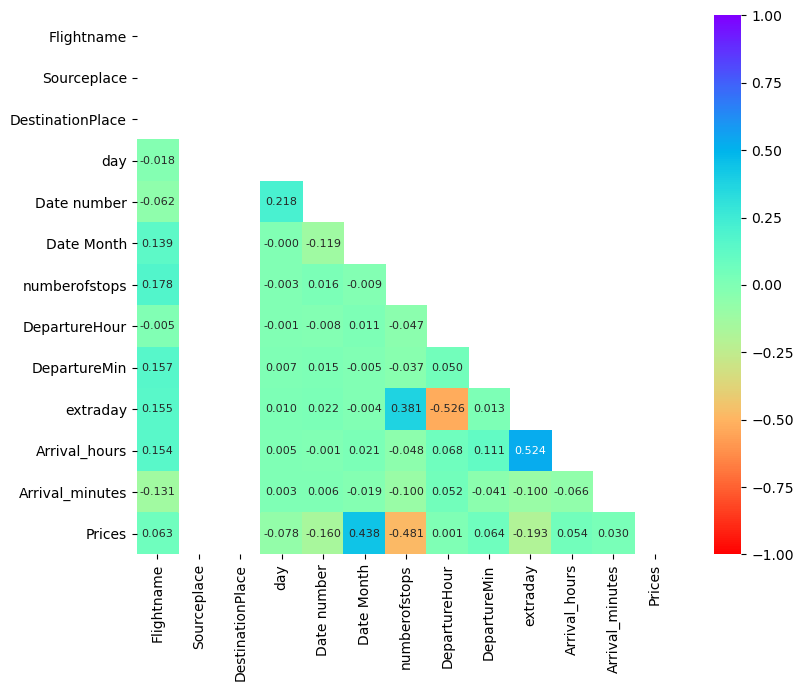

In [89]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, cmap="rainbow_r", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

With the help of about heatmap we are able to notice the correlation details between our label and feature and also amongst our labels. After eye balling the above heatmap we can see that there are no multi collinearity concerns in our dataset so we won't have to worry about dealing with them.

**2.Comparing features with label**

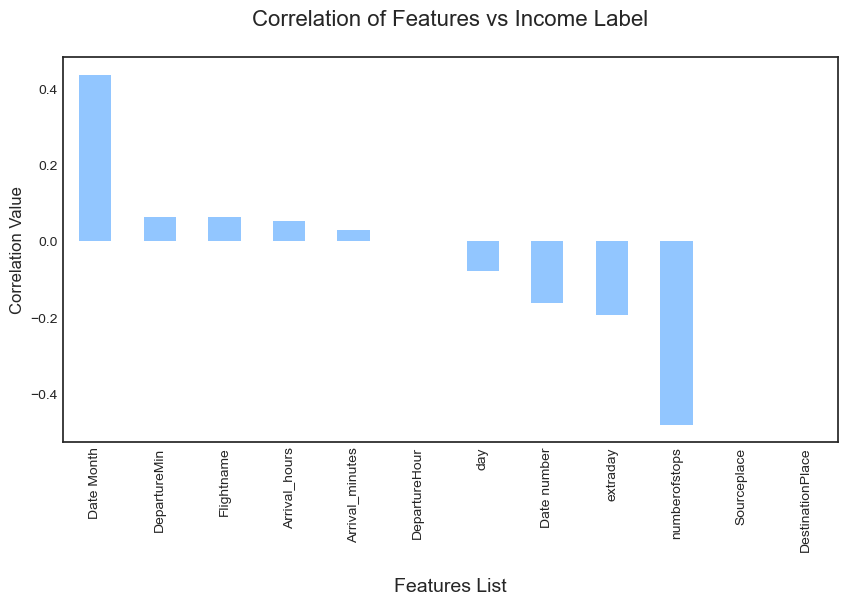

In [90]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(10,5))
df_corr['Prices'].sort_values(ascending=False).drop('Prices').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

With the usage of above bar plot for viewing the correlation information between our Features and Label 

we can see that columns Date Month,DepartureminFlightname,arrival_hours and arrival_minutes are positively correlated with our target.
Date Number,extra day and numberofstops are negatively correlated where total stops is highly negatively correlated indicating that as the number of total stops in an itinerary increases the price of that particular flight increases and vice a versa

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Flightname        2385 non-null   float64
 1   Sourceplace       2385 non-null   float64
 2   DestinationPlace  2385 non-null   float64
 3   day               2385 non-null   float64
 4   Date number       2385 non-null   int64  
 5   Date Month        2385 non-null   float64
 6   numberofstops     2385 non-null   float64
 7   DepartureHour     2385 non-null   int64  
 8   DepartureMin      2385 non-null   int64  
 9   extraday          2385 non-null   float64
 10  Arrival_hours     2385 non-null   int64  
 11  Arrival_minutes   2385 non-null   int64  
 12  Prices            2385 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 260.9 KB


# Splitting the dataset into 2 variables namely 'X' and 'Y' for features and label

In [92]:
X = df.drop('Prices', axis=1)
Y = df['Prices']

I have separated the dataset into features and label where X represents all the feature columns and Y represents the regression target label column.

# Feature Scaling

In [93]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head() # Displaying all the features after applying scaling technique to avoid bias output

,Flightname,Sourceplace,DestinationPlace,day,Date number,Date Month,numberofstops,DepartureHour,DepartureMin,extraday,Arrival_hours,Arrival_minutes
0,-1.647171,0.0,0.0,-0.837605,-1.524257,0.999234,-0.712395,1.439251,0.012867,-1.597013,-1.467803,1.205147
1,-1.647171,0.0,0.0,-0.837605,-1.524257,0.999234,-0.712395,1.439251,0.012867,-1.597013,-1.299005,-0.575693
2,-1.647171,0.0,0.0,-0.837605,-1.524257,0.999234,-0.712395,0.893584,0.546580,-1.597013,-1.467803,1.205147
3,-1.647171,0.0,0.0,-0.837605,-1.524257,0.999234,-0.712395,0.893584,0.546580,-1.597013,-1.299005,-0.575693
4,-1.647171,0.0,0.0,-0.837605,-1.524257,0.999234,-0.712395,1.621141,-0.787701,-1.597013,-0.455013,0.017920


Using the StandardScaler method to normalize the feature values and ensure that the regression model does not have any kind of biasness towards a particular column value.

# Finding the best random state for building Regression Models

In [96]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LinearRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    r2 = r2_score(Y_test, pred)
    
    if r2>maxAccu:
        maxAccu=r2
        maxRS=i

print("Best R2 score is", maxAccu,"on Random State", maxRS)

Best R2 score is 0.51779998830749 on Random State 533


# FEATURE IMPORTANCE

In [ ]:
rf=RandomForestRegressor()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

Here with the help of `RandomForestRegressor` we are able to list down the importance or priority given to a column as per it's involvement or weightage in predicting our label.

# Applying log transformation to our target variable

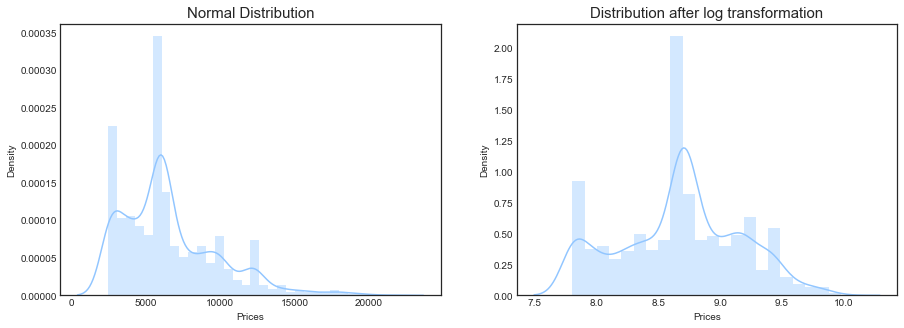

In [97]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Normal Distribution",fontsize=15)
sns.distplot(y)
plt.subplot(1,2,2)
plt.title("Distribution after log transformation",fontsize=15)
sns.distplot(np.log(y))
plt.show()


As we can see our target variable is right skewed thats why I will apply log transfomation to it for better results.

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Flightname        2385 non-null   float64
 1   Sourceplace       2385 non-null   float64
 2   DestinationPlace  2385 non-null   float64
 3   day               2385 non-null   float64
 4   Date number       2385 non-null   int64  
 5   Date Month        2385 non-null   float64
 6   numberofstops     2385 non-null   float64
 7   DepartureHour     2385 non-null   int64  
 8   DepartureMin      2385 non-null   int64  
 9   extraday          2385 non-null   float64
 10  Arrival_hours     2385 non-null   int64  
 11  Arrival_minutes   2385 non-null   int64  
 12  Prices            2385 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 260.9 KB


# Applying StandardScaler to numerical features

In [99]:
#lets apply standard scaler to numerical features to bring them to common scale
numeric = ['Departure_time','Time_of_arrival','Duration']
categorical = ['Airline','Source','Destination','Meal_availability','Number_of_stops']
scaler = StandardScaler()
X_numeric_std = pd.DataFrame(data=scaler.fit_transform(x[numeric]), columns=numeric)
X_std = pd.merge(X_numeric_std, x[categorical], left_index=True, right_index=True)

KeyError: "None of [Index(['Departure_time', 'Time_of_arrival', 'Duration'], dtype='object')] are in the [index]"

# Machine Learning Models and Evaluation

In [100]:
# Regression Model Function

#splits the training and testing features and labels
#then trains the model
#predicts the label,
#calculates the RMSE score
#generates the R2 score
#calculates the Cross Validation score 
#finds the difference between the R2 score and Cross Validation score.

def reg(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=533)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score is:", rmse)
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of r2 score minus cv score
    result = r2 - cv_score
    print("R2 Score - Cross Validation Score is", result)
    
    #plots created
    sns.regplot(Y_test,pred)
    plt.show()

RMSE Score is: 2181.3029641430317
R2 Score is: 51.779998830748994
Cross Validation Score: 3.758363160299494
R2 Score - Cross Validation Score is 48.0216356704495


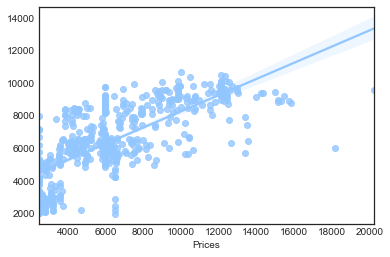

In [101]:
# Linear Regression Model
model=LinearRegression()
reg(model, X, Y)

RMSE Score is: 2182.3871646188486
R2 Score is: 51.732052129349526
Cross Validation Score: 4.055024524355588
R2 Score - Cross Validation Score is 47.67702760499394


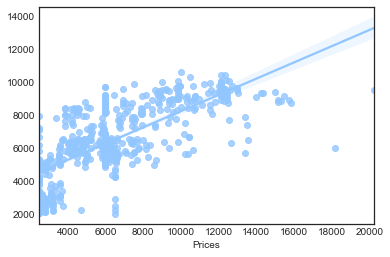

In [102]:
# Ridge Regression
model=Ridge(alpha=1e-2, normalize=True)
reg(model, X, Y)

RMSE Score is: 2181.332568898128
R2 Score is: 51.77868993323573
Cross Validation Score: 3.767193873255572
R2 Score - Cross Validation Score is 48.01149605998016


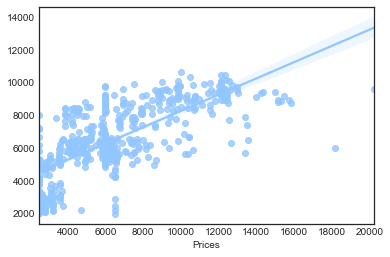

In [103]:
# Lasso Regression
model=Lasso(alpha=1e-2, normalize=True, max_iter=1e5)
reg(model, X, Y)

RMSE Score is: 3164.8126873377337
R2 Score is: -1.50589374007164
Cross Validation Score: -40.758774675142185
R2 Score - Cross Validation Score is 39.25288093507054


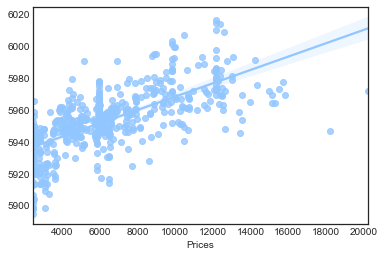

In [104]:
# Support Vector Regression
model=SVR(C=1.0, epsilon=0.2, kernel='poly', gamma='auto')
reg(model, X, Y)

RMSE Score is: 3133.4189139743607
R2 Score is: 0.4979201507747444
Cross Validation Score: -290.4215139672732
R2 Score - Cross Validation Score is 290.91943411804795


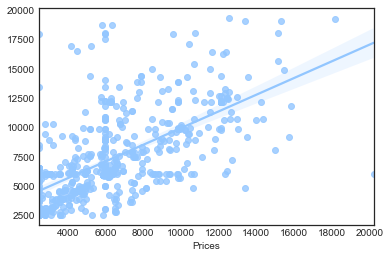

In [105]:
# Decision Tree Regressor
model=DecisionTreeRegressor(criterion="poisson", random_state=111)
reg(model, X, Y)

RMSE Score is: 2527.9934626498543
R2 Score is: 35.23399178447397
Cross Validation Score: -7.353622467729728
R2 Score - Cross Validation Score is 42.5876142522037


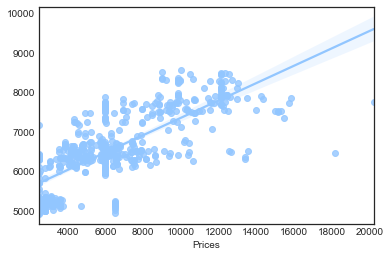

In [106]:
# Random Forest Regressor
model=RandomForestRegressor(max_depth=2, max_features="sqrt")
reg(model, X, Y)

RMSE Score is: 2455.364870254784
R2 Score is: 38.90195508228167
Cross Validation Score: -5.7949475081071355
R2 Score - Cross Validation Score is 44.6969025903888


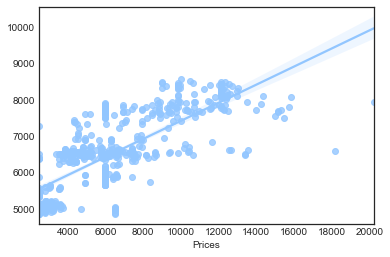

In [107]:
# K Neighbors Regressor
KNeighborsRegressor(n_neighbors=2, algorithm='kd_tree')
reg(model, X, Y)

RMSE Score is: 2344.2921917063827
R2 Score is: 44.3046779445684
Cross Validation Score: -55.75612754227859
R2 Score - Cross Validation Score is 100.06080548684699


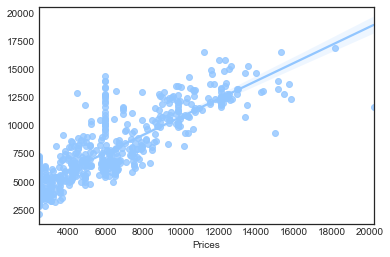

In [108]:
# Gradient Boosting Regressor
model=GradientBoostingRegressor(loss='quantile', n_estimators=200, max_depth=5)
reg(model, X, Y)

RMSE Score is: 2123.1125274573037
R2 Score is: 54.31840456182121
Cross Validation Score: 14.595684912708418
R2 Score - Cross Validation Score is 39.72271964911279


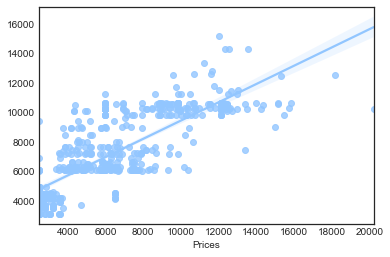

In [109]:
# Ada Boost Regressor
model=AdaBoostRegressor(n_estimators=300, learning_rate=1.05, random_state=42)
reg(model, X, Y)

RMSE Score is: 1395.2066756640559
R2 Score is: 80.272487435071
Cross Validation Score: 31.373321326202436
R2 Score - Cross Validation Score is 48.89916610886856


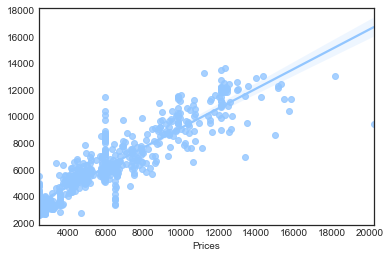

In [110]:
# Extra Trees Regressor
model=ExtraTreesRegressor(n_estimators=200, max_features='sqrt', n_jobs=6)
reg(model, X, Y)

RMSE Score is: 1303.0830680408667
R2 Score is: 82.79164166466654
Cross Validation Score: 22.32671846156723
R2 Score - Cross Validation Score is 60.46492320309932


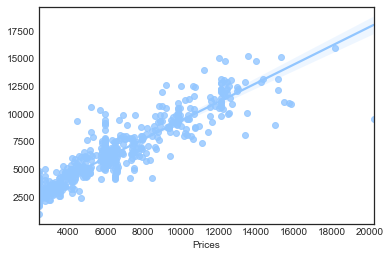

In [111]:
# XGB Regressor
model=XGBRegressor()
reg(model, X, Y)

RMSE Score is: 1280.6353271760524
R2 Score is: 83.37941929686585
Cross Validation Score: 44.63585914866849
R2 Score - Cross Validation Score is 38.74356014819736


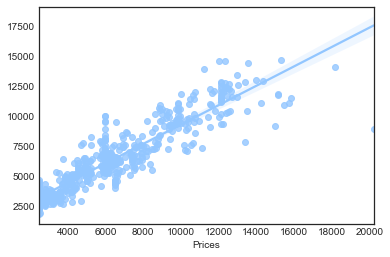

In [112]:
# LGBM Regressor
model=LGBMRegressor()
reg(model, X, Y)

# Hyper parameter tuning

I have chosen the XGB regressor as my best model since it is able to provide me the highest R2 score plus the model is doing better in Cross validation score too.
However the LGBM model is not chosen even though it has high score and low difference between r2 score and cross val score is because LGBM algorithm is better for datasets above 10,000 rows

In the below cell  all the parameters for LGBM regressor that can be used for hyper tuning our final model are listed

In [113]:
# Choosing XGB Regressor

fmod_param = {'booster' : ['gbtree','dart','gblinear'],
              'importance_type' : ['gain','split'],
              'n_estimators' : [100,200,500],
              'eta' : [0.001, 0.01, 0.1]
             }
GSCV = GridSearchCV(XGBRegressor(), fmod_param, cv=5)
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [114]:
GSCV.best_params_

{'booster': 'gbtree',
 'eta': 0.1,
 'importance_type': 'gain',
 'n_estimators': 200}

In [ ]:
Final_Model = XGBRegressor(booster='gbtree', eta=0.1, importance_type='gain', n_estimators=200)
regressor = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_r2 = r2_score(Y_test, fmod_pred)*100
print("R2 score for the Best Model is:", fmod_r2)

 final model is built using the hyper tuned parameters 

In [ ]:
#Saving the best Regression ML model
filename = "FinalModel_Flightprice.pkl"
joblib.dump(Final_Model, filename)

saved the best Regression model using the joblib library.

In [ ]:
y_pred=regressor.predict(X_test)

plt.scatter(Y_test,y_pred)
plt.xlabel('Actual chance of admission')
plt.ylabel('predicted chance of admission')
plt.title('actual vs model predicted')
plt.show()